# `PM2.5`: prediction and interpretability

##### **Objective**: Perform regression, given:
- Target: `PM2.5` - numerical continuous, right-skewed, non-linear dependencies mostly.
- Data: hourly time series, strong autocorrelation, seasonality and meteorological covariates.
- Requirements: high predictive **accuracy** + (optionally) valid interpretability.

---

## Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import lightgbm as lgb
from itertools import product
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from sklearn.inspection import permutation_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import time
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.stattools import durbin_watson
import joblib
from math import prod
from lightgbm import early_stopping
import optuna

In [2]:
from utils import (
    detect_perfect_multicollinearity_via_rank, perform_VIF, plot_correlations, check_stationarity_adf, sarimax_search,
    breusch_pagan_test, het_arch_test, pick_ljungbox_lags_for_regression
)

## Data import

In [3]:
# constants
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
data_folder_path = "data"
TARGET = "PM2.5"

# data import
df_train = pd.read_csv(os.path.join(data_folder_path, 'processed', "02_df_train_imputed.csv"), index_col=0)
df_test = pd.read_csv(os.path.join(data_folder_path, 'processed', "02_df_test_imputed.csv"), index_col=0)

df_train.head()

,year,PM10,SO2,NO2,CO,O3,PRES,RAIN,WSPM,hour_sin,...,day_sin,day_cos,dayofweek_sin,dayofweek_cos,wd_deg,season,is_weekend,PM2.5,RH,working_hour_component
datetime,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,2013,4.0,4.0,7.0,300.0,77.0,1023.0,0.0,4.4,0.000000,...,0.0,1.0,-0.433884,-0.900969,0.0,2,0,4.0,23.878120,0.0
2013-03-01 01:00:00,2013,8.0,4.0,7.0,300.0,77.0,1023.2,0.0,4.7,0.258819,...,0.0,1.0,-0.433884,-0.900969,0.0,2,0,8.0,25.880955,0.0
2013-03-01 02:00:00,2013,7.0,5.0,10.0,300.0,73.0,1023.5,0.0,5.6,0.500000,...,0.0,1.0,-0.433884,-0.900969,0.0,2,0,7.0,25.880955,0.0
2013-03-01 03:00:00,2013,6.0,11.0,11.0,300.0,72.0,1024.5,0.0,3.1,0.707107,...,0.0,1.0,-0.433884,-0.900969,315.0,2,0,6.0,23.872562,0.0
2013-03-01 04:00:00,2013,3.0,12.0,12.0,300.0,72.0,1025.2,0.0,2.0,0.866025,...,0.0,1.0,-0.433884,-0.900969,0.0,2,0,3.0,24.737858,0.0


## Model selection overview

### Nature of the task

As we previously saw on the pair-plots, the data hardly shows any signs of significant linearity. And where it is roughly present, it is scattered. Based on this, tree-based models are most likely to be a final `PM2.5` prediction model.

We have performed certain assumption checks for both the missingness inference and their imputation. They were different sets because the models and the goals were different themselves. They were also different problems of regression and classification. For the same reason, different multicollinearity-resolving steps were taken. 

Currently, the problem is regression again. This time, it is without a significant need for inference. We would want to be able to conclude or "debug" the predictions, but the ultimate goal is **accuracy**. In order to complete the task, brief assumption check is performed again after the imputation, which might have brought in new dependencies and (potentially) inflations.

### Model selection

The first options to think of when handling non-linear regression are `trees` and `deep-networks`. While `trees` can fit non-linear interactions well and are strong predictors, they ignore temporal dependence (autocorrelation, seasonality) treating observations as independent and identically distributed (i.i.d.). This way, they might capture spurious patterns. `Deep models`, however, are able to capture both non-linearities and seasonality, but require too much data to surpass the `trees` in accuracy. Time series regressors that are simpler will not account for non-linearities and therefore, will not surpass the `trees` either. Dilemma overview:
- Time-series–aware regressors:
    - `ARIMAX` / `SARIMAX`. They explicitly model autocorrelation and seasonality; better for interpretation, but limited on non-linearities (our case).
    - State-space models (Kalman filter, Dynamic Regression). Flexible, highly interpretable, handle time-varying effects, but limited on non-linearities (our case).
- Hybrid approaches:
    - Boosted `Trees` (`LightGBM`/`XGB`) but with manually added lagged features. Higher predictive power. Possible to interpret and adjust using permutation importance / SHAP.
- `Deep models`:
    - `RNNs`/`LSTMs`/Temporal `CNN`s. Capture long-term temporal dependence with highest predictive power, but interpretability drops drastically (fuzzy interpretation with special tools involved - against our objective); they are heavy and require too much data (we have fewer).

Ultimately:
- For the current amount of observations (`28,000` in train), `deep networks` are not considered. 
- Both families in the `time-series–aware regressors` mostly assume linearity, but explicitly model autocorrelation and have high interpretability; they cannot be the final predictive power, but have the potential to become a good baseline to compare against. 
- The `trees`, within the current constraints and the goal of accuracy over interpretation, are the most suitable applicants. To account for missing time dependencies, we are going to utilize `boosted trees` with manually added time-aware features. We will be using permutation importance / SHAP for interpretability if possible. 

To summarize:
`SARIMAX` is being utilized as a baseline due to its ability to handle autocorrelation and seasonality while also accounting for exogenous variables. If our hybrid approach accounting for non-linear patterns with manually modeled autocorrelation doesn't surpass the linear `SARIMAX`, we might pay more attention to how we model the time structure or get back to linear relationships.

## Assumption check

### Overview

While the goal is not interpretability, we are going to briefly check **all** the assumptions. If the baseline is only for prediction comparison, one might think we don’t need statistical inference, however, `trees` don’t give confidence intervals naturally. `SARIMAX` does, if assumptions hold. That can be useful for:
- benchmarking prediction uncertainty - aims to understand how accurate and trustworthy a model's confidence in its predictions truly is; relevant for model selection
- checking model fit quality - we can't seriously compare against a baseline if it fails badly on (even inference) assumptions (extremely heteroscedastic, autocorrelated residuals etc.). Thus, comparing its accuracy to `trees` would be unfair — comparing “mis-specified stats model” vs “flexible ML model”.

### Data consistency

#### Column types

In [4]:
df_train.dtypes

year                        int64
PM10                      float64
SO2                       float64
NO2                       float64
CO                        float64
O3                        float64
PRES                      float64
RAIN                      float64
WSPM                      float64
hour_sin                  float64
month_sin                 float64
month_cos                 float64
day_sin                   float64
day_cos                   float64
dayofweek_sin             float64
dayofweek_cos             float64
wd_deg                    float64
season                      int64
is_weekend                  int64
PM2.5                     float64
RH                        float64
working_hour_component    float64
dtype: object

We don't change the bits in types because `numpy` and most built-in algorithms that use it will upcast the types automatically.

#### Column classification

In [4]:
numerical_continuous_cols = ['year', TARGET, 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'PRES', 'RAIN', 'WSPM', 'wd_deg', 'RH']
cyclical_cols = ['hour_sin', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'working_hour_component']
ordinal_categorical_cols = ['is_weekend', 'season']
nominal_categorical_groups = {}

print(f"Are all columns classified? {(len(numerical_continuous_cols) + len(cyclical_cols) + len(ordinal_categorical_cols) + len(nominal_categorical_groups.keys()))==len(df_train.columns)}")

Are all columns classified? True


### Sufficient overlap and data

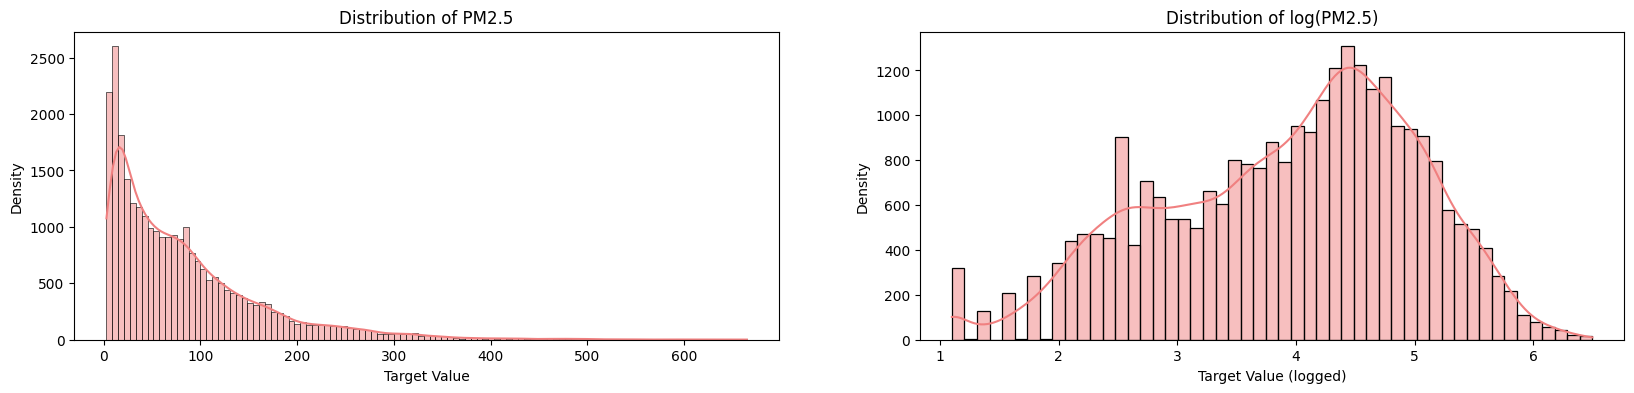

In [6]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,4))

sns.histplot(df_train[TARGET], kde=True, color='lightcoral', ax=ax[0])
ax[0].set_title(f'Distribution of {TARGET}')
ax[0].set_xlabel('Target Value')
ax[0].set_ylabel('Density')

sns.histplot(np.log(df_train[TARGET]), kde=True, color='lightcoral', ax=ax[1])
ax[1].set_title(f'Distribution of log({TARGET})')
ax[1].set_xlabel('Target Value (logged)')
ax[1].set_ylabel('Density')

plt.show()

Raw target (right-skewed):
- Regression errors will be dominated by the majority of lower values.
- Higher values might be poorly predicted. 

Log-transformed:
- Turns right-skew into something closer to normal / Gaussian-like.
- Regression assumptions (residuals approximately normal, constant variance) are better satisfied.

In [5]:
# preserve original dfs
df_train_raw = df_train.copy()
df_test_raw = df_test.copy()

In [6]:
df_train[TARGET] = np.log(df_train[TARGET])
df_test[TARGET] = np.log(df_test[TARGET])

LOG_TARGET = f'log_{TARGET}'
df_train = df_train.rename(columns={TARGET: LOG_TARGET})
df_test = df_test.rename(columns={TARGET: LOG_TARGET})

numerical_continuous_cols.remove(TARGET)
numerical_continuous_cols.append(LOG_TARGET)

### Collinearity

Letting high multicollinearity slide could lead to misrepresentation of feature importance (if used) and `SARIMAX` is directly vulnerable to it because of its linear regression component for exogenous variables.

In [7]:
detect_perfect_multicollinearity_via_rank(dataframe=df_train, target=LOG_TARGET, verbose=True)

Matrix rank: 21 / 21 features


(False, 21)

In [8]:
vif_table = perform_VIF(data_frame_no_nulls=df_train,
            encoded_predictors=list(df_train.columns), 
            target=LOG_TARGET
            )

vif_table.head(10)

,feature,VIF
12,month_cos,4.513519
11,month_sin,3.936999
7,PRES,3.745191
4,NO2,3.561290
5,CO,3.491476
18,season,3.161967
20,RH,2.932871
19,is_weekend,2.856183
6,O3,2.770900
15,dayofweek_sin,2.765358


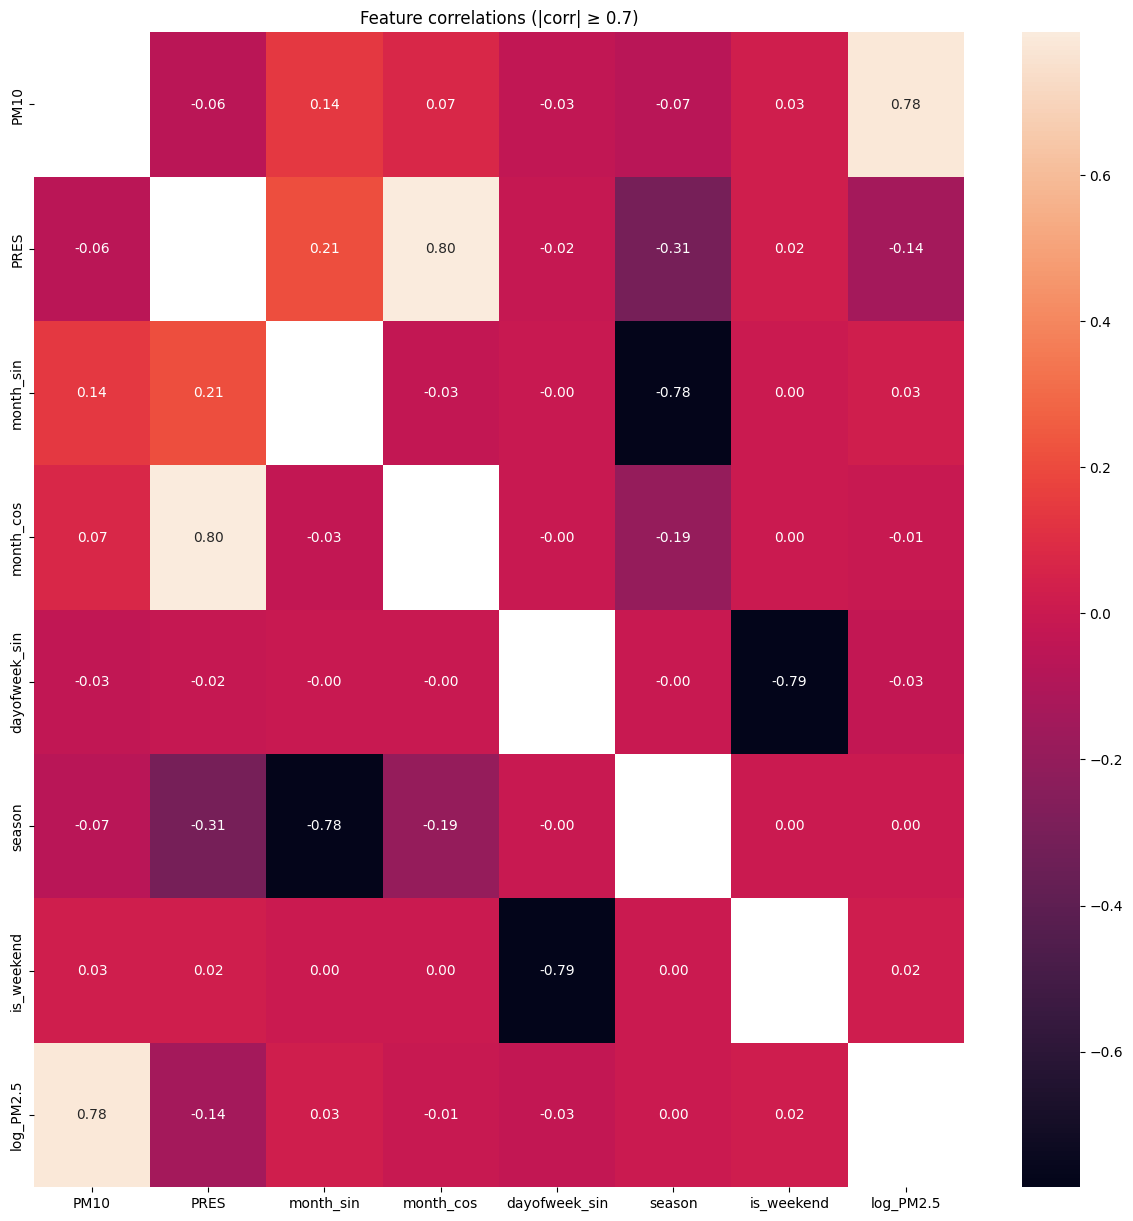

In [9]:
correlations = plot_correlations(df_train, df_train.columns.tolist(), f'Feature correlations', 0.7)

Among highly-correlated pairs in `Pearson`'s (`|r| > 0.7` strictly speaking) are:
- `0.78`: `PM10` & `log_PM2.5` - naturally correlated phenomena within the current domain
- `-0.78`: `month_sin` & `season` - both features reflect monthly seasonality from different perspectives, one might be extra
- `-0.79`: `dayofweek_sin` & `is_weekend` - both feature reflect daily seasonality from different perspectives, one might be extra
- `0.8`: `month_cos` & `PRES` - adjacent concepts where `PRES` is strongly associated with seasonality, they are different concepts

`LGBM`: It is likely that we do not need to take action in terms of predictability. The low `VIF` (< 5 - according to basic guidelines) is a strong indicator that the high pairwise correlations are not causing severe multicollinearity problems. But they reflect different correlation dependencies and should be considered separately as well. So, prediction-wise, we are going to let the `tree` model figure it out by itself.
`SARIMAX`: Considering the troublesome and ambiguous predictors, the least interpretable ones (`month_sin` and `dayofweek_sin`) are going to be dropped only for this model.

In [10]:
df_train_interpret = df_train.copy()
df_test_interpret = df_test.copy()

df_train_interpret = df_train_interpret.drop(columns=['month_sin', 'dayofweek_sin'])
df_test_interpret = df_test_interpret.drop(columns=['month_sin', 'dayofweek_sin'])

In [11]:
vif_table = perform_VIF(data_frame_no_nulls=df_train_interpret,
            encoded_predictors=list(df_train_interpret.columns), 
            target=LOG_TARGET
            )

vif_table.head(10)

,feature,VIF
4,NO2,3.543531
11,month_cos,3.497809
5,CO,3.468017
7,PRES,3.430003
18,RH,2.717861
6,O3,2.650324
2,PM10,2.404413
3,SO2,2.292162
9,WSPM,1.829231
16,season,1.708192


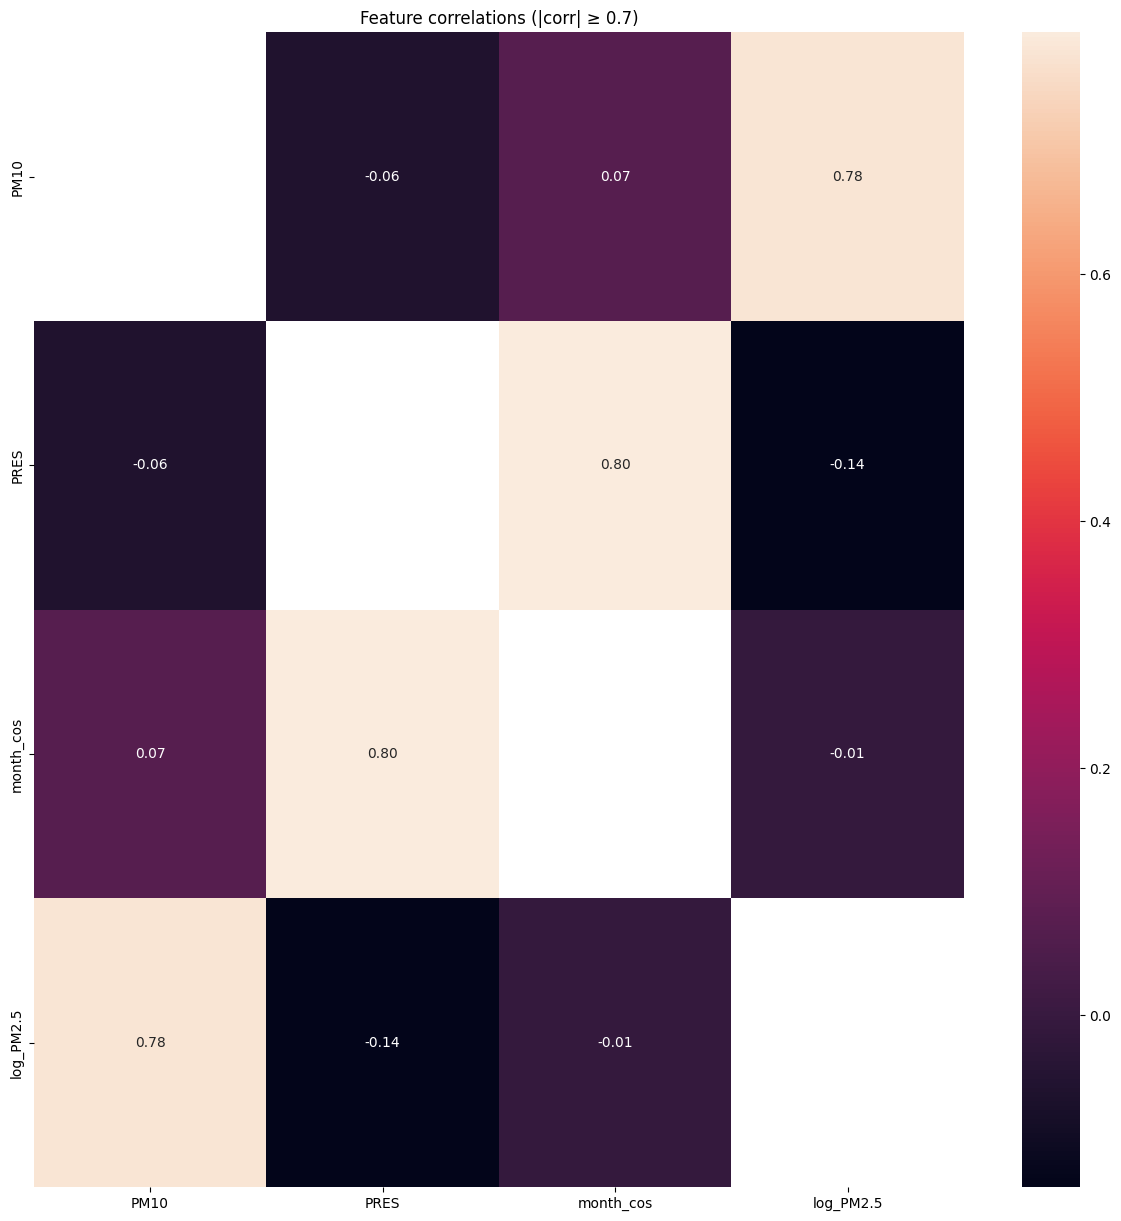

In [12]:
correlations = plot_correlations(df_train_interpret, df_train_interpret.columns.tolist(), f'Feature correlations', 0.7)

### Baseline fit + tree model selection

#### Baseline fit and tuning

All other assumptions onwards are checked post-fit. To fit a model properly, we need to determine `SARIMAX` parameters first (the baseline). 

Overview: `m` or `s` - cycle length. Small `p`, `d`, `q` - short memory terms, capital `P`, `D`, `Q` - seasonal memory terms (repeated long-term). They are usually picked automatically with existent algorithms like `auto_arima`. However, it may take hours even for `28,000` observations. Therefore, the goal of this research is to narrow down the search to time-acceptable range. The research is being conducted using ACF/PACF for both short- and long-term parameters.

- `m`/`s` (seasonal period length) - how long before the seasonal pattern repeats; "scale context" of the below parameters. `7` for weekly cycle if observations are days, `24` for daily if observations are hours (out case) etc.
- `p` (AR order) - how many lagged values to use (if today’s `PM2.5` depends on yesterday’s or two days ago etc.)
- `d` (difference order) - how many diff values to use (if `PM2.5` keeps steadily rising - say +2 each day - the model can’t handle that directly. Differencing removes it)
- `q` (MA order) - how many lagged errors to include (if yesterday was unusually polluted (model underpredicted), today’s level is partly explained by that leftover shock)
- `P` (seasonal AR) - e.x., today’s `PM2.5` looks like the same day last week
- `D` (seasonal differencing) - e.x., each winter the `PM2.5` rises steadily, but the pattern repeats every year
- `Q`  (seasonal MA) - e.x., if last week’s Tuesday was unexpectedly polluted, this week’s Tuesday may carry that residual effect

In [15]:
# Augmented Dickey–Fuller test (ADF)
print(f"Is {LOG_TARGET} stationary? {check_stationarity_adf(df_train[LOG_TARGET], verbose=False)['is_stationary']}")

Is log_PM2.5 stationary? True


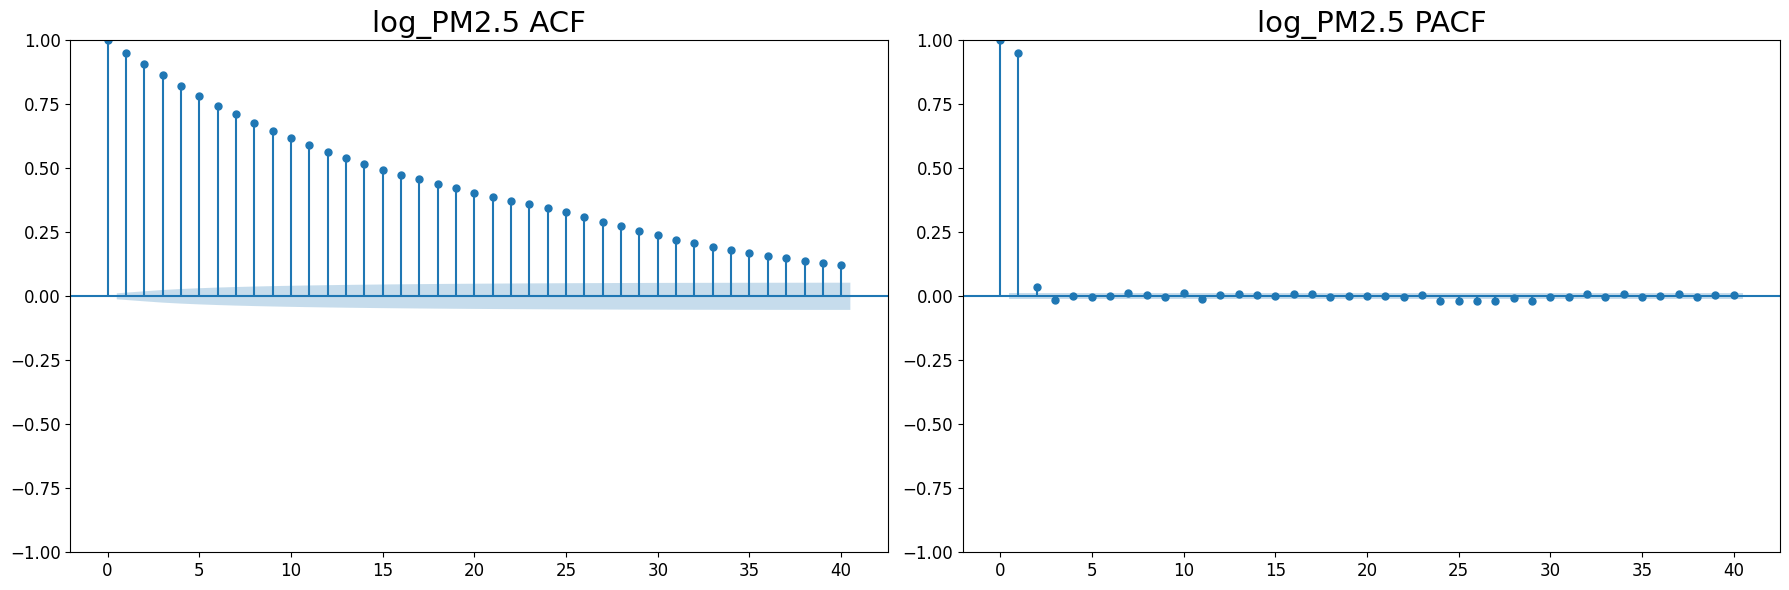

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6))

plot_acf(df_train[LOG_TARGET], lags=40, ax=axes[0])
plot_pacf(df_train[LOG_TARGET], lags=40, ax=axes[1])

# title font size
axes[0].set_title(f'{LOG_TARGET} ACF', fontsize=21)
axes[1].set_title(f'{LOG_TARGET} PACF', fontsize=21)

# axis font size
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

The target is stationary (`ADF`), but exhibit trends (`ACF`). However, there are no clear seasonal spikes, the model has autoregressive behavior, `AR(1)` to be specific. 
- The value of `s` is determined by domain logic (no explicit seasonality) and is set to `24` because each observation represents an hour and a single measure.
- `p` = `0..1` - the target is AR(1)
- `d` = `0` - the target is stationary; no differencing needed
- `q` = `0..1` - no signs of MA, but it's a common practice to add 1 just in case, to account for residual autocorrelation after adding lags, diffs, etc.
- `P` = `0..1` - no big spikes in ACF at multiples, so set the same as `p`
- `D` = `0` - the target is stationary; no differencing needed
- `Q` = `0..1` - no big spikes in ACF at multiples, so set the same as `q`

Instead of using `auto_arima` from `pmdarima`, we are intoducing a custom function. This one more agile than the existent `auto_arima`, which, while being great, comes with its flaws:
- requires outdated `numpy`
- takes too long to run unless you set it to *stepwise* (still no progress bar)
- no proper printing progress
- you can't set a custom timeout interval if a fit takes too long etc.

For these reasons, we are introducing custom `sarimax_search` as an automated hyperparameter search for `SARIMAX`:
- fits `SARIMAX` models across ranges of (p,d,q) × (P,D,Q), calculating the overall amount of combinations to run
- prints progress
- supports:
    - Grid search: exhaustive over all combinations.
    - Stepwise search: local hill-climbing (tries neighbors iteratively).
- selects best model based on lowest AIC.

In [13]:
# explicitly set the frequency (suppresses undesired warnings and helps avoid unexpected behavior)
df_train_interpret.index = pd.to_datetime(df_train_interpret.index)
df_train_interpret.index.freq = 'h'

In [15]:
best_res, current_order, current_seasonal, best_aic = sarimax_search(y=df_train_interpret[LOG_TARGET],
                                                                     m=24, # domain logic because there were no explicit seasonal spikes at multiples
                                                                     max_p=1, # we know the data is AR(1)
                                                                     max_d=0, # no difference needed based on ADF
                                                                     max_q=1, # rarely > 1 (unless ACF shows a sharp cutoff at the specific lag); setting '1' just in case
                                                                     max_P=1, # no significant spikes at acf/pacf, max 2
                                                                     max_D=0, # d > 1 will result in very long convergence; d=1 is often enough if data is seasonal
                                                                     max_Q=1, # same as max_q (unless we see big spikes in ACF at multiples)
                                                                     mode="grid", # fewer combinations to try -> grid
                                                                     verbose=True) # print progress

print(f"Best orders: {current_order}, {current_seasonal} with AIC = {best_aic:.4f}")

Search mode = grid
Total models to fit: 16


  6%|▋         | 1/16 [00:00<00:03,  3.84it/s]

Trying order=(0, 0, 0), seasonal=(0, 0, 0), m=24, AIC=158517.00


 12%|█▎        | 2/16 [00:06<00:53,  3.79s/it]

Trying order=(0, 0, 0), seasonal=(0, 0, 1), m=24, AIC=132459.70


 19%|█▉        | 3/16 [00:11<00:58,  4.49s/it]

Trying order=(0, 0, 0), seasonal=(1, 0, 0), m=24, AIC=90945.95


 25%|██▌       | 4/16 [00:35<02:24, 12.03s/it]

Trying order=(0, 0, 0), seasonal=(1, 0, 1), m=24, AIC=83746.77


 31%|███▏      | 5/16 [00:37<01:34,  8.56s/it]

Trying order=(0, 0, 1), seasonal=(0, 0, 0), m=24, AIC=123109.25


 38%|███▊      | 6/16 [00:49<01:35,  9.54s/it]

Trying order=(0, 0, 1), seasonal=(0, 0, 1), m=24, AIC=101475.85


 44%|████▍     | 7/16 [01:00<01:30, 10.08s/it]

Trying order=(0, 0, 1), seasonal=(1, 0, 0), m=24, AIC=66388.56


 50%|█████     | 8/16 [01:52<03:08, 23.50s/it]

Trying order=(0, 0, 1), seasonal=(1, 0, 1), m=24, AIC=57065.91


 56%|█████▋    | 9/16 [01:54<01:57, 16.77s/it]

Trying order=(1, 0, 0), seasonal=(0, 0, 0), m=24, AIC=19299.58


 62%|██████▎   | 10/16 [02:05<01:29, 14.92s/it]

Trying order=(1, 0, 0), seasonal=(0, 0, 1), m=24, AIC=19282.28


 69%|██████▉   | 11/16 [02:14<01:05, 13.16s/it]

Trying order=(1, 0, 0), seasonal=(1, 0, 0), m=24, AIC=19281.82


 75%|███████▌  | 12/16 [03:18<01:54, 28.67s/it]

Trying order=(1, 0, 0), seasonal=(1, 0, 1), m=24, AIC=18497.11


 81%|████████▏ | 13/16 [03:19<01:00, 20.29s/it]

Trying order=(1, 0, 1), seasonal=(0, 0, 0), m=24, AIC=19201.71


 88%|████████▊ | 14/16 [03:29<00:34, 17.02s/it]

Trying order=(1, 0, 1), seasonal=(0, 0, 1), m=24, AIC=19186.20


 94%|█████████▍| 15/16 [03:42<00:16, 16.01s/it]

Trying order=(1, 0, 1), seasonal=(1, 0, 0), m=24, AIC=19187.12


100%|██████████| 16/16 [05:30<00:00, 20.63s/it]

Trying order=(1, 0, 1), seasonal=(1, 0, 1), m=24, AIC=18438.10
Best orders: (1, 0, 1), (1, 0, 1) with AIC = 18438.0954


The best combination is `(1,0,1), (1,0,1, 24)` resulting in the minimum of Akaike Information Criterion (`AIC`) of `18438.1` (trade-off between model fit and complexity). The absolute value is not interpretable by itself — only differences matter (basic rules are ΔAIC < 2 - models are about equally good, ΔAIC > 10 - one model is much worse). We conclude that this model is significantly better than the others.

In [16]:
baseline_model = best_res
resid_sarimax = baseline_model.resid
y_pred_sarimax = baseline_model.fittedvalues

#### Tree model and metric-selection

The further conclusions and assumptions are going to be model-specific and in order to address any issues, we would want to find the best model first. We are going to compare tree models efficiency and accuracy to determine the superior.

Metric-wise, we prioritize `RMSE` over `MAE` to account for sensor- and season-based reading inconsistencies observed earlier (therefore penalizing larger mistakes more).

We are also creating custom scorers to revert logarithmized target.

In [18]:
# custom scorers to revert log-predictions
def mae_exp(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

def rmse_exp(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred)))

scoring = {
    'MAE': make_scorer(mae_exp, greater_is_better=False),
    'RMSE': make_scorer(rmse_exp, greater_is_better=False),
    'R2': 'r2'
}

In [ ]:
def objective(trial, X, y, model_name):
    tss = TimeSeriesSplit(n_splits=5)
    val_scores_rmse = []
    train_scores_rmse = []
    val_scores_mae = []
    train_scores_mae = []
    train_r2_scores = []
    val_r2_scores = []

    for train_idx, val_idx in tss.split(X):
        Xtr, Xval = X.iloc[train_idx], X.iloc[val_idx]
        ytr, yval = y.iloc[train_idx], y.iloc[val_idx]

        # sample params per model
        if model_name == "LGBM":
            model = lgb.LGBMRegressor(
                learning_rate=trial.suggest_float("learning_rate", 0.09, 0.11),
                num_leaves=trial.suggest_int("num_leaves", 29, 32),
                max_depth=trial.suggest_int("max_depth", 20, 23),
                min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 18, 23),
                n_estimators=trial.suggest_int("n_estimators", 80, 120),
                n_jobs=-1,
                random_state=RANDOM_SEED
            )
        elif model_name == "XGB":
            model = XGBRegressor(
                learning_rate=trial.suggest_float("learning_rate", 0.09, 0.11),
                max_depth=trial.suggest_int("max_depth", 6, 10),
                subsample=trial.suggest_float("subsample", 0.7, 0.9),
                colsample_bytree=trial.suggest_float("colsample_bytree", 0.7, 0.9),
                n_estimators=trial.suggest_int("n_estimators", 80, 120),
                n_jobs=-1,
                random_state=RANDOM_SEED
            )
        elif model_name == "CatBoost":
            model = CatBoostRegressor(
                learning_rate=trial.suggest_float("learning_rate", 0.09, 0.11),
                depth=trial.suggest_int("depth", 6, 10),
                l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1, 5),
                iterations=trial.suggest_int("iterations", 80, 120),
                silent=True,
                random_state=RANDOM_SEED
            )
        elif model_name == "RandomForest":
            model = RandomForestRegressor(
                n_estimators=trial.suggest_int("n_estimators", 80, 120),
                max_depth=trial.suggest_int("max_depth", 10, 20),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 10, 20),
                n_jobs=-1,
                random_state=RANDOM_SEED
            )
        elif model_name == "ExtraTrees":
            model = ExtraTreesRegressor(
                n_estimators=trial.suggest_int("n_estimators", 80, 120),
                max_depth=trial.suggest_int("max_depth", 10, 20),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 10, 20),
                n_jobs=-1,
                random_state=RANDOM_SEED
            )
        else:
            raise ValueError(f"Unknown model {model_name}")

        # fit and predict
        model.fit(Xtr, ytr)
        pred_val = model.predict(Xval)
        pred_tr = model.predict(Xtr)

        train_scores_mae.append(mae_exp(ytr, pred_tr))
        val_scores_mae.append(mae_exp(yval, pred_val))

        train_scores_rmse.append(rmse_exp(ytr, pred_tr))
        val_scores_rmse.append(rmse_exp(yval, pred_val))

        train_r2_scores.append(r2_score(ytr, pred_tr))
        val_r2_scores.append(r2_score(yval, pred_val))


    # set all custom attrs to print out
    trial.set_user_attr("train_mae", float(np.mean(train_scores_mae)))
    trial.set_user_attr("val_mae", float(np.mean(val_scores_mae)))
    trial.set_user_attr("train_rmse", float(np.mean(train_scores_rmse)))
    trial.set_user_attr("val_rmse", float(np.mean(val_scores_rmse)))
    trial.set_user_attr("train_r2", float(np.mean(train_r2_scores)))
    trial.set_user_attr("val_r2", float(np.mean(val_r2_scores)))

    # return a single value for optuna optimization algorithm
    return float(np.mean(val_scores_rmse))

In [19]:
X_train = df_train.drop(columns=[LOG_TARGET])
y_train = df_train[LOG_TARGET]

jobs = os.cpu_count() - 1

In [81]:
study_lgbm = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_lgbm.optimize(lambda t: objective(t, X_train, y_train, "LGBM"), n_trials=30)

study_xgb = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_xgb.optimize(lambda t: objective(t, X_train, y_train, "XGB"), n_trials=30)

study_cb = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_cb.optimize(lambda t: objective(t, X_train, y_train, "CatBoost"), n_trials=30)

study_rf = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_rf.optimize(lambda t: objective(t, X_train, y_train, "RandomForest"), n_trials=30)

study_et = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_et.optimize(lambda t: objective(t, X_train, y_train, "ExtraTrees"), n_trials=30)

[I 2025-10-02 14:30:49,811] A new study created in memory with name: no-name-3fa3c1c5-027f-480f-b585-26c77448630d
[I 2025-10-02 14:30:51,220] Trial 0 finished with value: 16.111956795875443 and parameters: {'learning_rate': 0.09749080237694725, 'num_leaves': 32, 'max_depth': 22, 'min_data_in_leaf': 21, 'n_estimators': 86}. Best is trial 0 with value: 16.111956795875443.
[I 2025-10-02 14:30:52,835] Trial 1 finished with value: 15.759705851499424 and parameters: {'learning_rate': 0.09311989040672405, 'num_leaves': 29, 'max_depth': 23, 'min_data_in_leaf': 21, 'n_estimators': 109}. Best is trial 1 with value: 15.759705851499424.
[I 2025-10-02 14:30:54,040] Trial 2 finished with value: 16.075907173617892 and parameters: {'learning_rate': 0.09041168988591605, 'num_leaves': 32, 'max_depth': 23, 'min_data_in_leaf': 19, 'n_estimators': 87}. Best is trial 1 with value: 15.759705851499424.
[I 2025-10-02 14:30:55,514] Trial 3 finished with value: 16.03203749035641 and parameters: {'learning_rate':

In [113]:
studies = {
    'LGBM': study_lgbm, 
    'XGB': study_xgb,
    'CatBoost': study_cb,
    'RandomForest': study_rf,
    'ExtraTrees': study_et
}

results = pd.DataFrame(index=studies.keys(), columns=['train_MAE', 'train_RMSE', 'train_R2', 'valid_MAE', 'valid_RMSE', 'valid_R2', 'abs_val_train_gap_rmse'])

for name, study_obj in studies.items():
    results.loc[name, 'train_MAE'] = study_obj.best_trial.user_attrs['train_mae']
    results.loc[name, 'train_RMSE'] = study_obj.best_trial.user_attrs['train_rmse']
    results.loc[name, 'train_R2'] = study_obj.best_trial.user_attrs['train_r2']
    results.loc[name, 'valid_MAE'] = study_obj.best_trial.user_attrs['val_mae']
    results.loc[name, 'valid_RMSE'] = study_obj.best_trial.user_attrs['val_rmse']
    results.loc[name, 'valid_R2'] = study_obj.best_trial.user_attrs['val_r2']
    results.loc[name, 'abs_val_train_gap_rmse'] = abs(study_obj.best_trial.user_attrs['val_rmse']-study_obj.best_trial.user_attrs['train_rmse'])

results.sort_values(by=['abs_val_train_gap_rmse', 'valid_RMSE', 'valid_MAE'])

,train_MAE,train_RMSE,train_R2,valid_MAE,valid_RMSE,valid_R2,abs_val_train_gap_rmse
RandomForest,6.240477,14.186871,0.967638,8.271854,16.414384,0.945045,2.227513
ExtraTrees,6.676960,14.538045,0.965587,8.740322,17.104884,0.943631,2.566839
LGBM,6.689149,13.159353,0.975168,8.250848,15.759706,0.945666,2.600353
CatBoost,7.952340,14.704705,0.965243,9.200911,17.966265,0.945060,3.261560
XGB,5.929690,10.713529,0.982773,8.314204,16.188254,0.945064,5.474724


### Independent residuals (no autocorrelation)

#### Autocorrelation in SARIMAX

`SARIMAX`, unlike trees, automatically models seasonality **in data**, but it still worth checking for autocorrelation **in residuals**. It models autocorrelation in the mean and if the model is misspecified (didn’t capture all the structure in the data with the given parameters), autocorrelation might be still present in the residuals. 

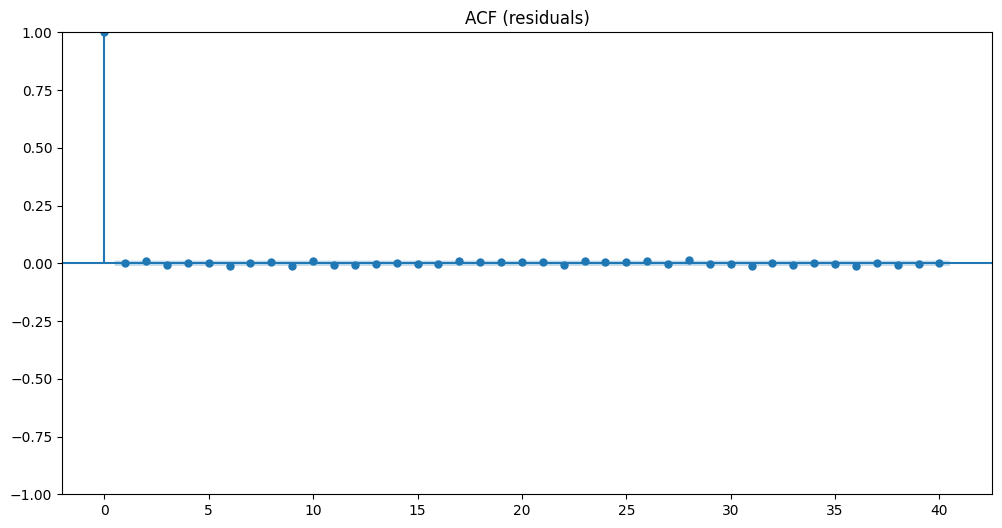

In [20]:
# --- Plot ACF residuals ---
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(resid_sarimax, lags=40, ax=ax)
ax.set_title("ACF (residuals)")
plt.show()

No autocorrelation is found in `SARIMAX`. No actions needed.

#### Autocorrelation in LGBM

In order for the `trees` to take time into account and therefore enhance predictions, we need to manually create (model) those time dependencies. Thus, it is necessary to check if residuals accumulate the errors over time (are autocorrelated). The patterns in which those errors accumulate will make the process of modelling clearer. If there is autocorrelation, we may use `Ljung-Box`-based greedy algorithm to model the structure. 

If we had a different superior model like `ExtraTrees` or `RandomForest`, a single fit might take a while, so a simple `OLS` would be considered then in the greedy search with the final check of engineered features on the final model. `LGBM` is well-known for its speed, so we are incorporating it directly into the custom greedy lag search (`pick_ljungbox_lags_for_regression`).

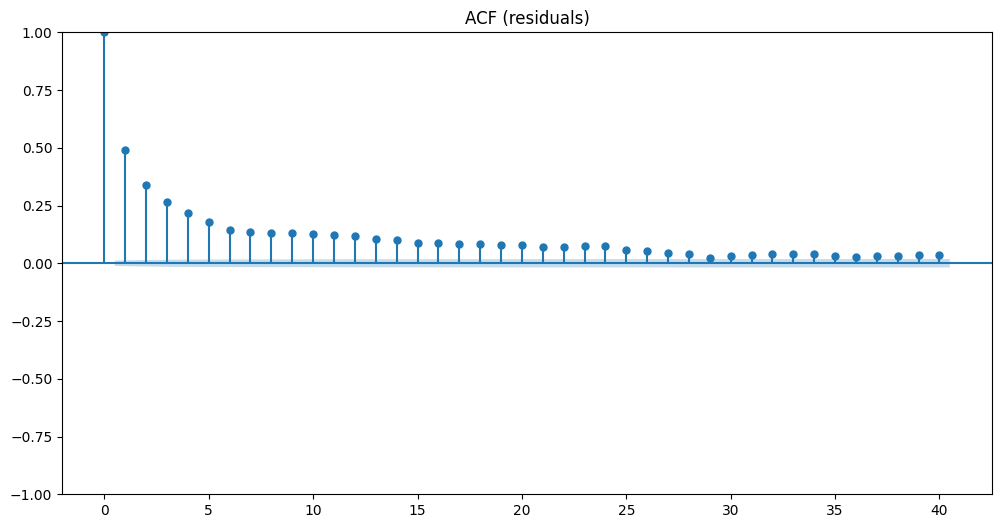

In [21]:
# --- LGBMRegressor fit ---
X = df_train.drop(columns=[LOG_TARGET])
y = df_train[LOG_TARGET]

model_lgbm = lgb.LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        max_depth=20,
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=200,
        min_data_in_leaf=50,
        random_state=RANDOM_SEED,
        verbose=-1,
        n_jobs=jobs
        )

model_lgbm.fit(X, y)
y_pred_lgbm = model_lgbm.predict(X)
resid_lgbm = y - y_pred_lgbm

# --- Plot ACF residuals ---
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(resid_lgbm, lags=40, ax=ax)
ax.set_title("ACF (residuals)")
plt.show()

Autoregressive behavior confirms that autocorrelation in residuals is present and needs to be addressed. Deriving sensible features based on domain knowledge is performed to narrow down the search. If the features are already stationary AND uncorrelated across lags (flat `ACF`), their lagged versions won't help and there's no need to consider them being involved in this problem at all. If the `ACF` is flat, it means the current values of the feature are not linearly related to their past values. In other words, the feature has no memory — knowing the past does not help predict the present.

In [23]:
sensible_features = [LOG_TARGET, 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'PRES', 'RAIN', 'WSPM', 'RH']

for feat in sensible_features:
    print(f"Is {feat} stationary? {check_stationarity_adf(df_train[feat], verbose=False)['is_stationary']}")

Is log_PM2.5 stationary? True
Is PM10 stationary? True
Is SO2 stationary? True
Is NO2 stationary? True
Is CO stationary? True
Is O3 stationary? True
Is PRES stationary? True
Is RAIN stationary? True
Is WSPM stationary? True
Is RH stationary? True


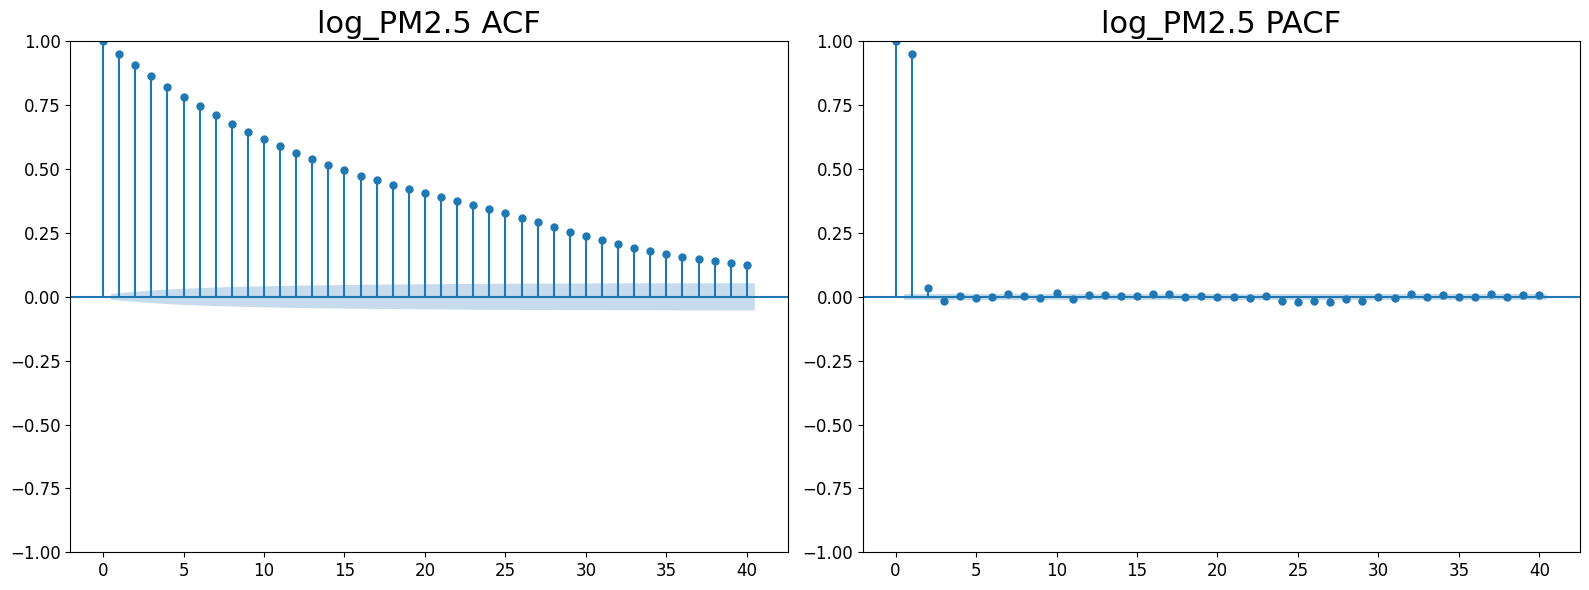

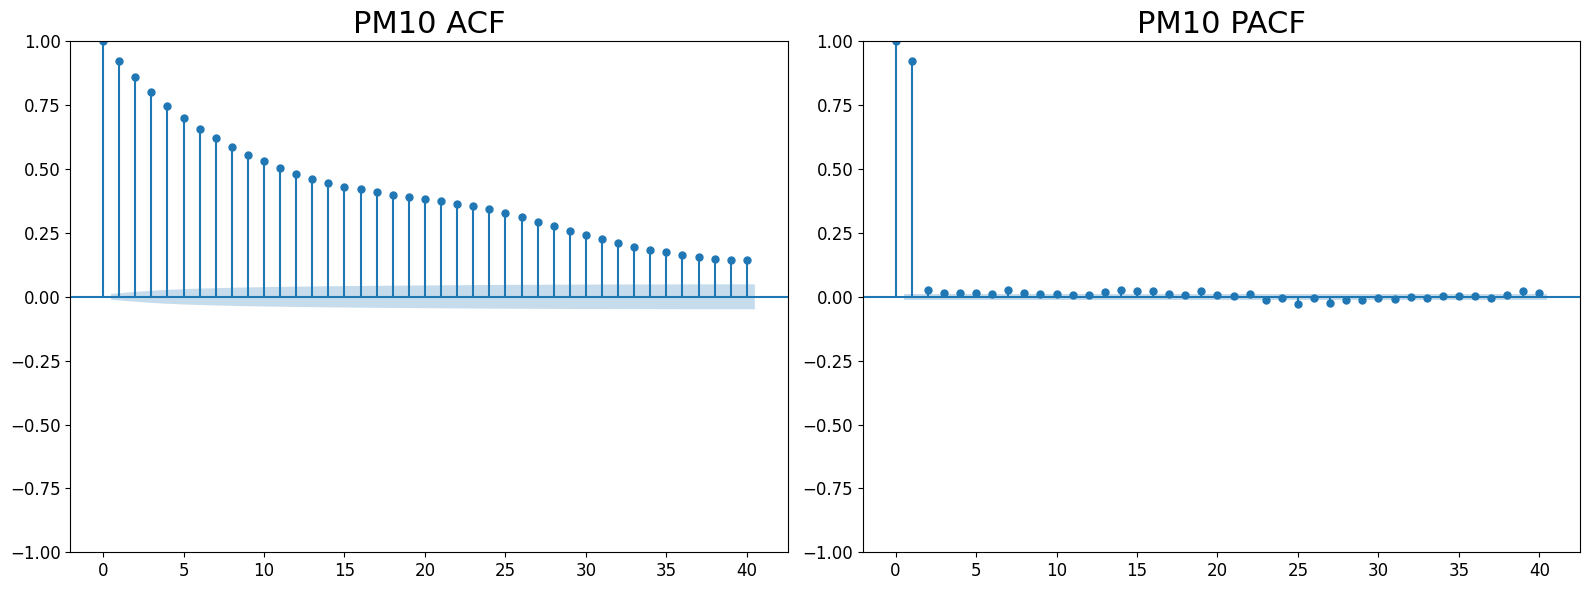

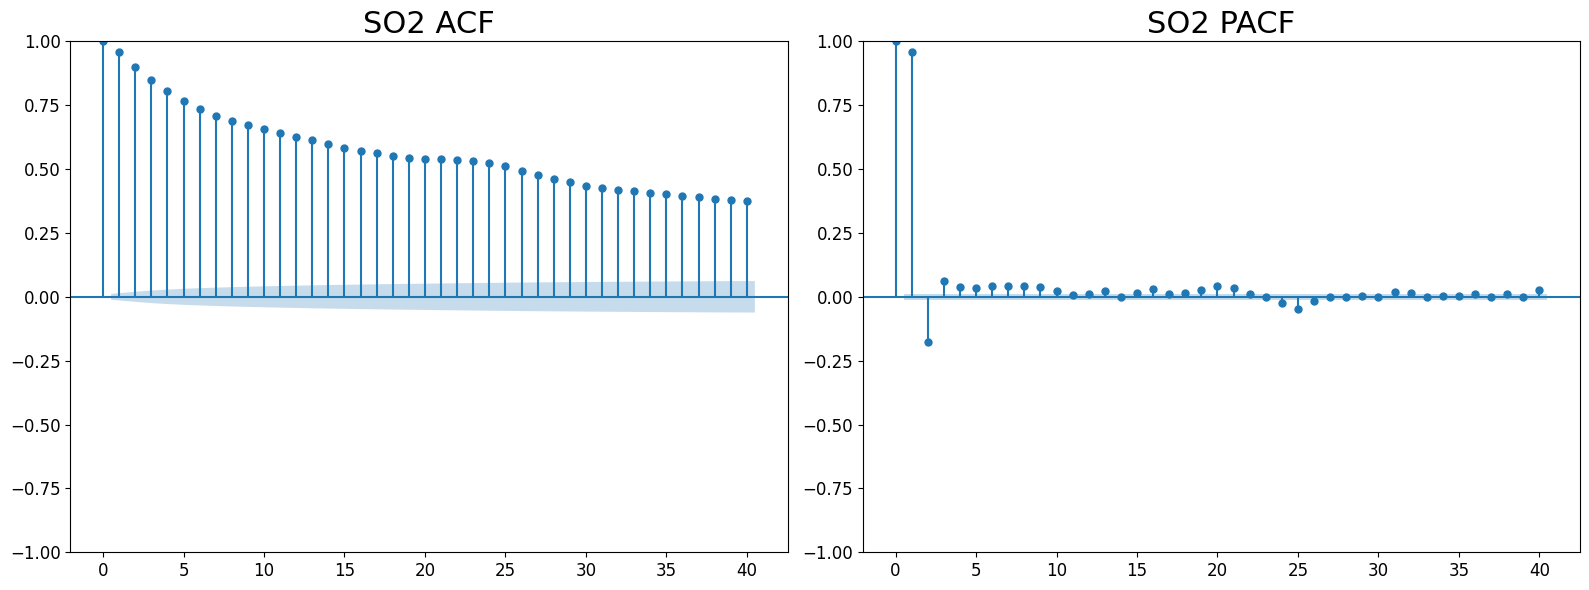

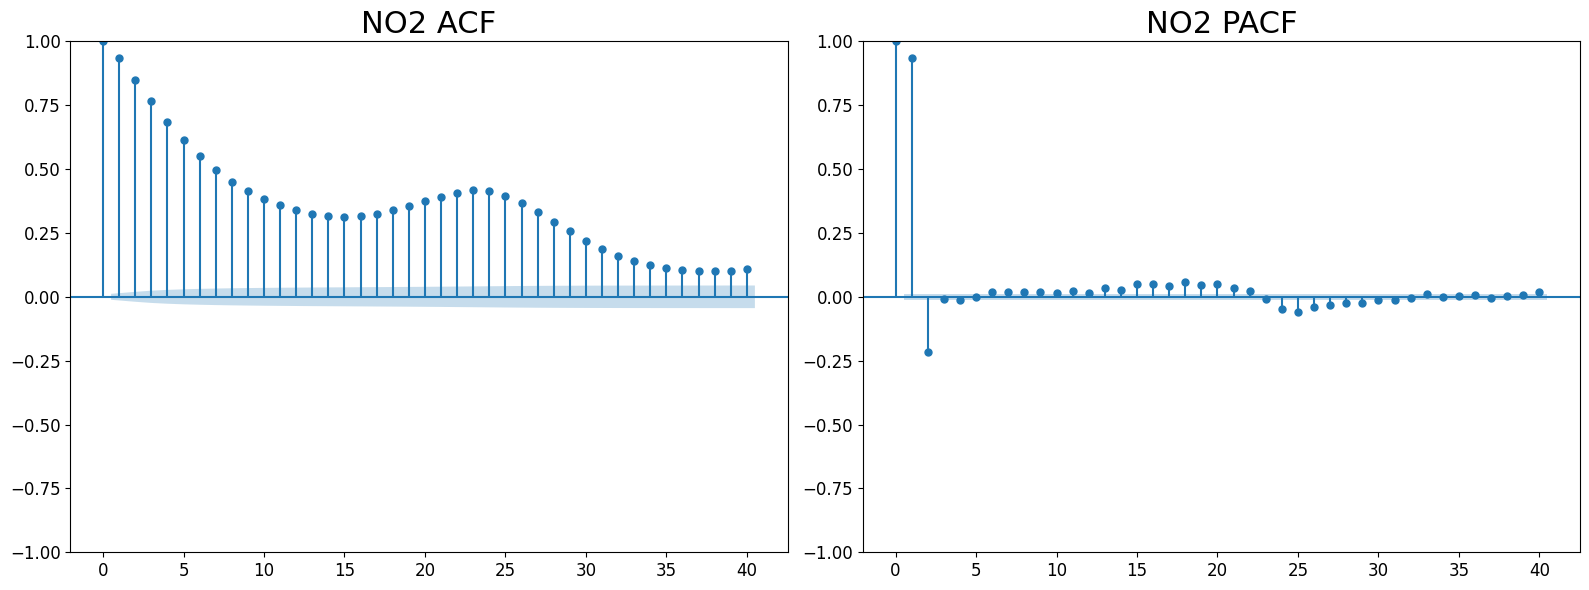

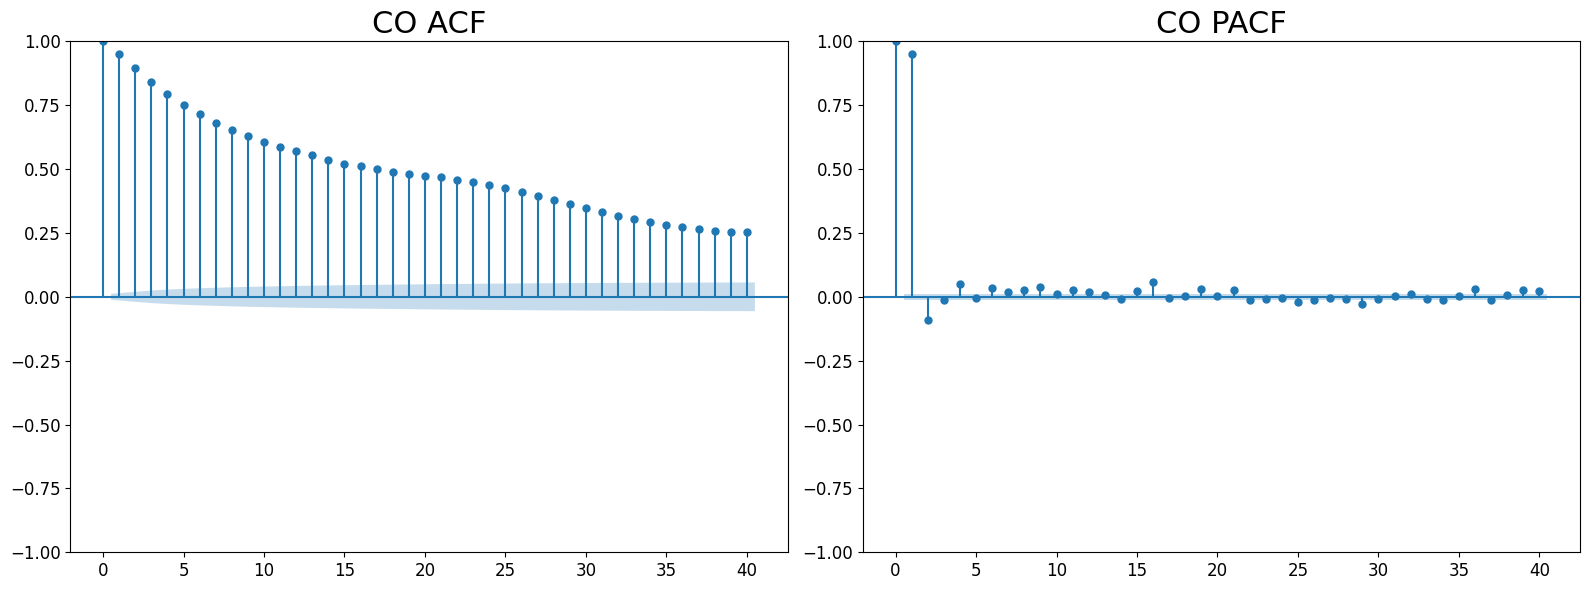

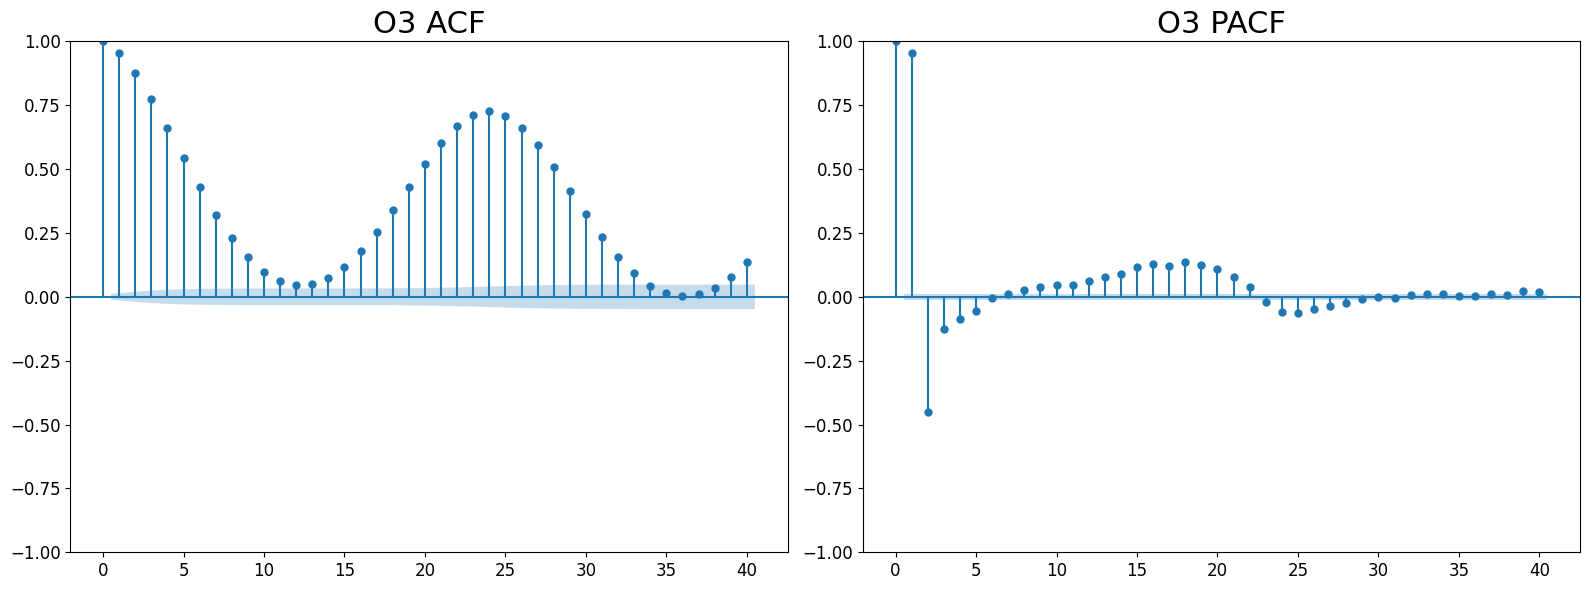

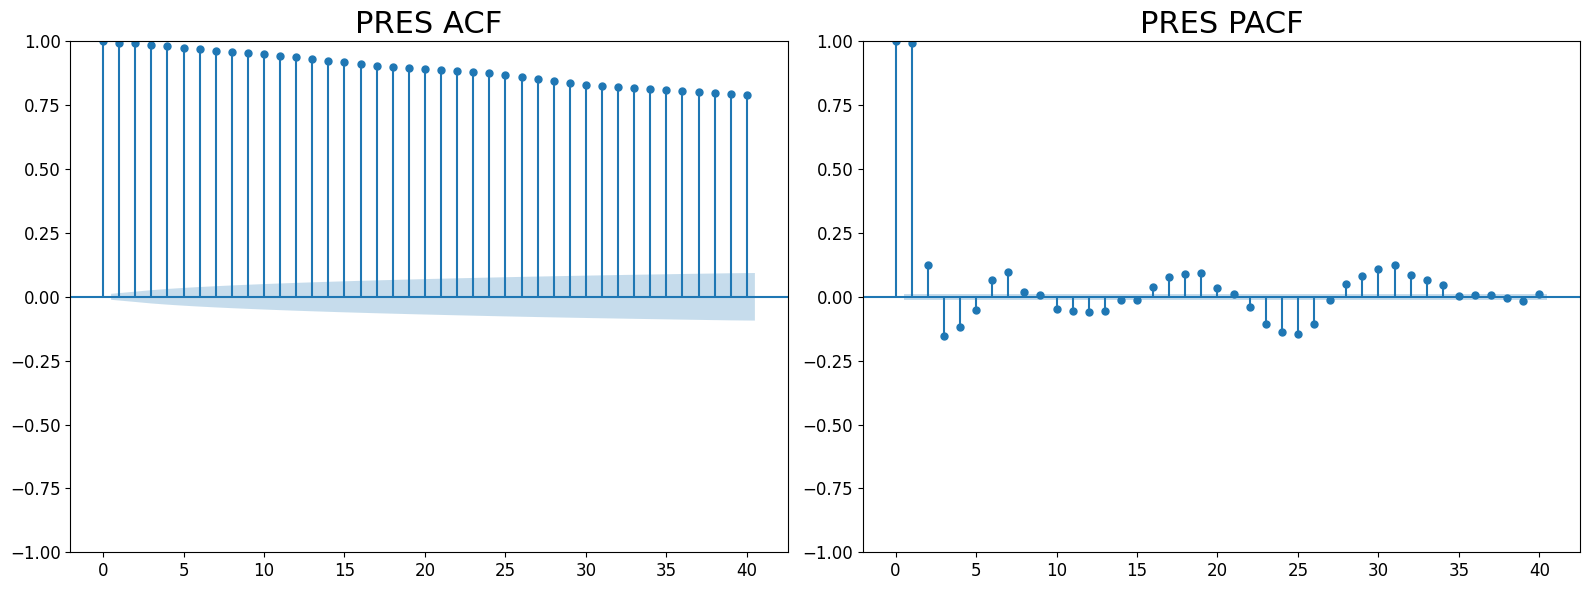

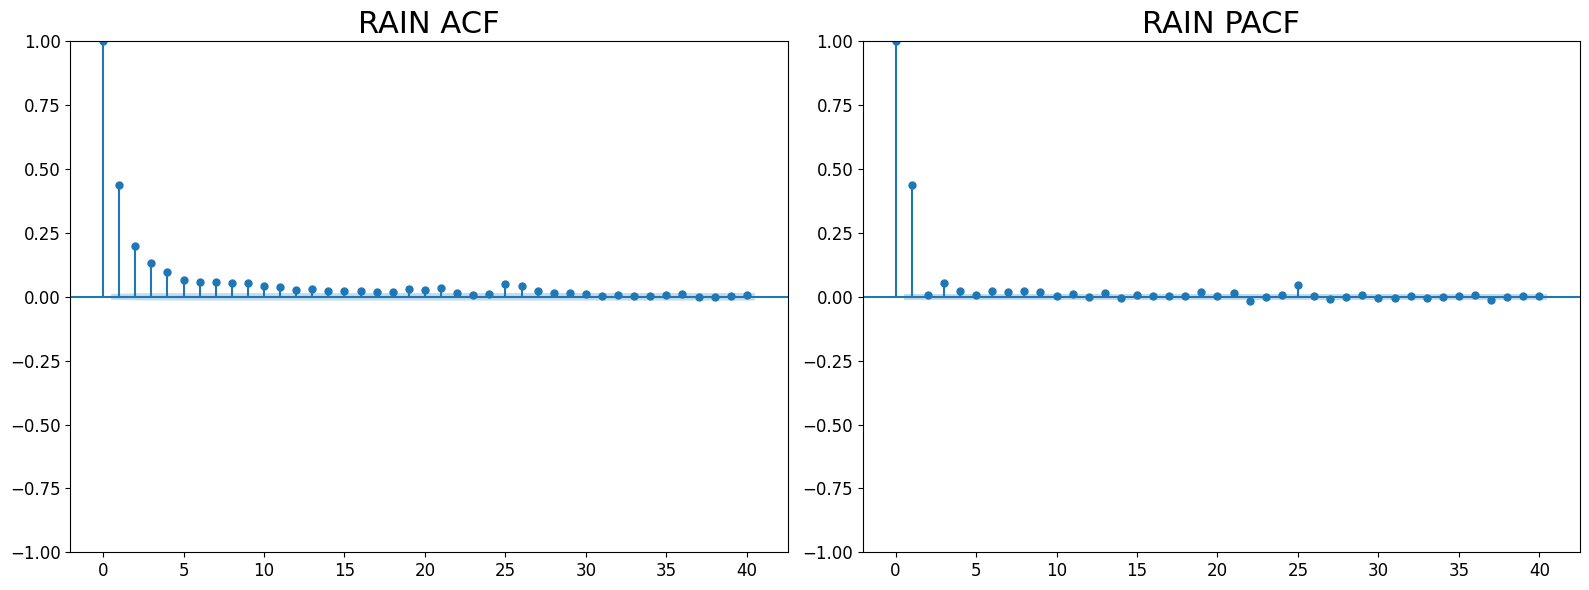

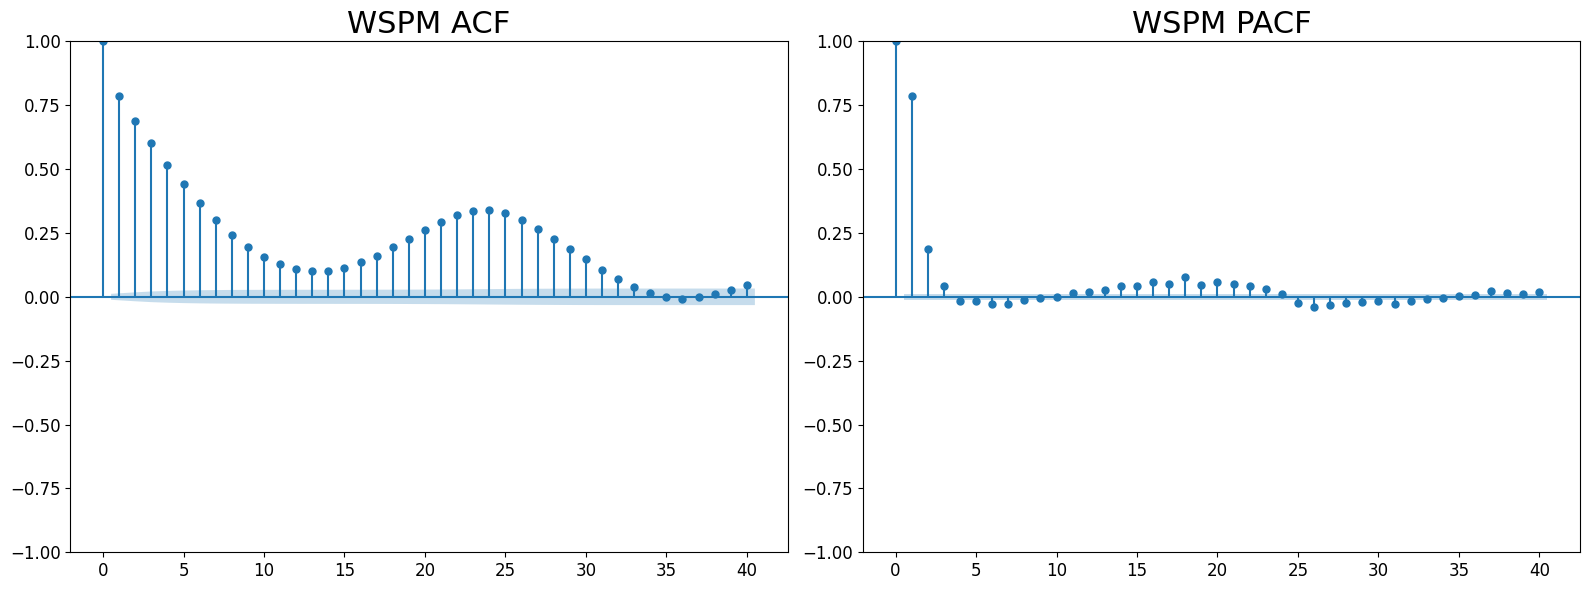

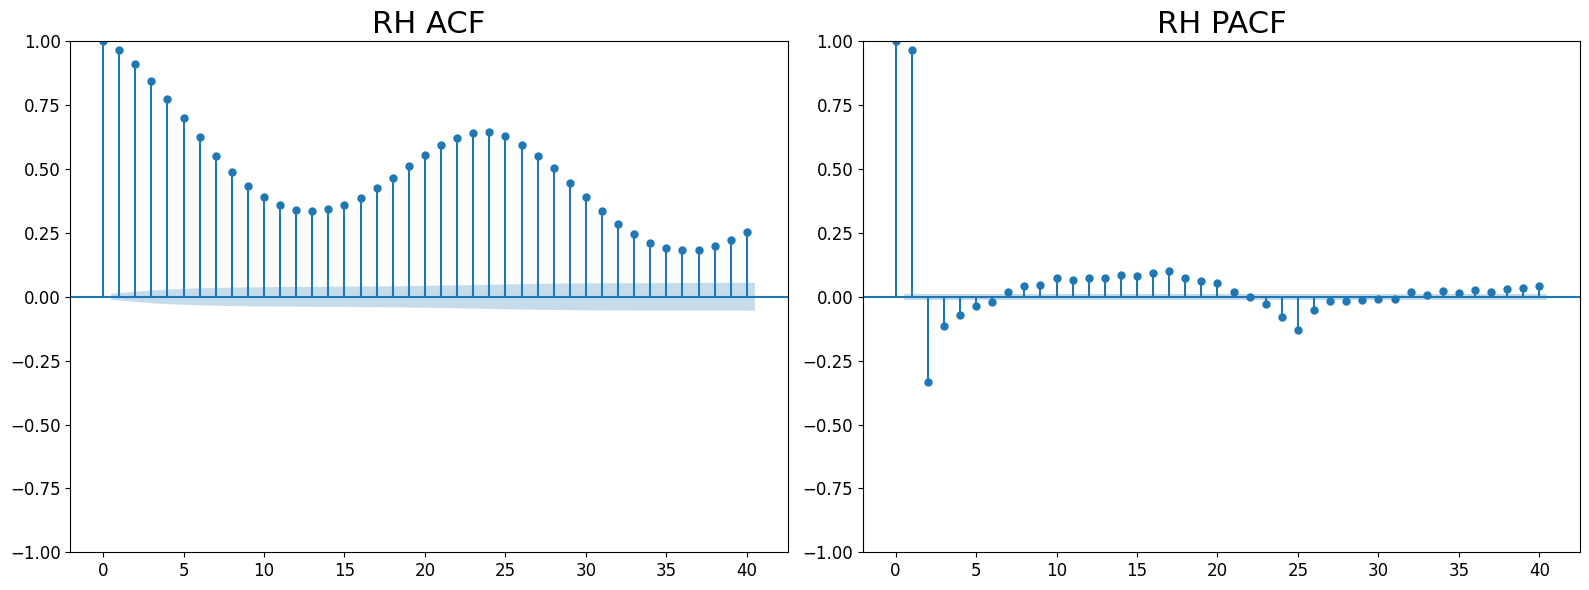

In [36]:
for f in sensible_features:
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))

    plot_acf(df_train[f], lags=40, ax=axes[0])
    plot_pacf(df_train[f], lags=40, ax=axes[1])

    # title font size
    axes[0].set_title(f'{f} ACF', fontsize=22)
    axes[1].set_title(f'{f} PACF', fontsize=22)

    # axis font size
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[1].tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    plt.show()

- `PM2.5` - AR(1). Classic autoregression process when each value depends on the one before it. Evidence: ACF decays slowly, PACF abruptly cuts off after certain value. The modelling: lagged target (1)
- `PM10` - AR(1). Same as `PM2.5`. The modelling: lagged `PM10` (1)
- `SO2` - AR(1). Same as `PM2.5`. The modelling: lagged `SO2` (1)
- `NO2` - ARMA(1, 3). Autoregressive moving average process when both ACF and PACF have features of AR and MA. Evidence: both gradually tail off + abruptness in PACF. The modelling: lagged `NO2` (1) + smoothed/rolling (3).
- `CO` - AR(1). Same as `PM2.5`. The modelling: lagged `CO` (1)
- `O3` - ARMA(1, 6). The modelling: lagged `O3` (1) + smoothed/rolling (6)
- `PRES` - ARMA(1,5). Same as `NO2`, but PACF shows oscillation. The modelling: lagged `PRES` (1), smoothed/rolling (5)
- `RAIN` - AR(1). Same as `PM2.5`. The modelling: lagged `RAIN` (1)
- `WSPM` - ARMA(1, 3). The modelling: lagged `WSPM` (1) + smoothed/rolling (3)
- `RH` - ARMA(1, 6). The modelling: lagged `RH` (1) + smoothed/rolling (6)

All selected features may be helpful, each of them reflects signs of seasonality. The goal is to eliminate strong positive autocorrelation in residuals by adding as fewer features as possible. Attempting only lag features first (referring to AR(1) target) while using greedy forward set selection in combinations:

In [38]:
ljungbox_lags_df = pick_ljungbox_lags_for_regression(data_frame=df_train, 
                                                     candidate_features=sensible_features,
                                                     target_var=LOG_TARGET, 
                                                     lag_degree=1, 
                                                     max_combo_size=3,
                                                     rand_seed=RANDOM_SEED,
                                                     log_scale=True)

ljungbox_lags_df.head(15)

Expected number of combinations: 175
Progress: 10/175 (5.7%)
Progress: 20/175 (11.4%)
Progress: 30/175 (17.1%)
Progress: 40/175 (22.9%)
Progress: 50/175 (28.6%)
Progress: 60/175 (34.3%)
Progress: 70/175 (40.0%)
Progress: 80/175 (45.7%)
Progress: 90/175 (51.4%)
Progress: 100/175 (57.1%)
Progress: 110/175 (62.9%)
Progress: 120/175 (68.6%)
Progress: 130/175 (74.3%)
Progress: 140/175 (80.0%)
Progress: 150/175 (85.7%)
Progress: 160/175 (91.4%)
Progress: 170/175 (97.1%)


,combo,lb_pvalue,lb_stat,acf_1,MAE,RMSE,cand_len,max_vif_col,max_vif_score,abs_acf_1
0,"(log_PM2.5, PM10)",7.420622e-171,882.492604,-0.028241,6.641436,13.184431,2,year,8.393019,0.028241
1,"(log_PM2.5, PM10, PRES)",5.506262e-175,901.989698,-0.028294,6.640083,13.175850,3,year,117.159018,0.028294
2,"(log_PM2.5, PM10, O3)",5.297155e-177,911.507888,-0.032096,6.628403,13.187172,3,year,16.569598,0.032096
3,"(log_PM2.5, PM10, NO2)",7.282368e-179,920.292187,-0.033909,6.602062,13.136024,3,year,11.661310,0.033909
4,"(log_PM2.5, PM10, RAIN)",2.416644e-179,922.552180,-0.028104,6.639664,13.176556,3,year,8.395725,0.028104
5,"(log_PM2.5, PM10, SO2)",6.597174e-181,929.928822,-0.037224,6.600101,13.153786,3,year,13.559977,0.037224
6,"(log_PM2.5, PM10, CO)",1.631760e-182,937.506101,-0.051424,6.532621,13.052188,3,year,14.505780,0.051424
7,"(log_PM2.5, PM10, WSPM)",5.915642e-183,939.583991,-0.026832,6.630205,13.137893,3,year,8.413135,0.026832
8,"(log_PM2.5, PM10, RH)",4.396163e-189,968.473572,-0.027576,6.618933,13.182542,3,year,20.429263,0.027576
9,"(log_PM2.5, NO2, PRES)",1.394277e-244,1229.291223,0.019647,7.005744,13.884173,3,year,117.217991,0.019647


The best combination is `log_PM2.5` + `PM10`. Although the `p-value` is approaching zero (`7.420622e-171`), it is only due to sample size degrading; `MAE`/`RMSE`, nevertheless, are relatively low - `6.64` and `13.18` respectively; `VIF` < `10` and `|ACF|` = `0.03` - extremely small, which is most important, because now, when we plot `ACF` and there is no huge spikes anymore, it means we have successfully modelled the structure and may conclude that this assumption holds true.

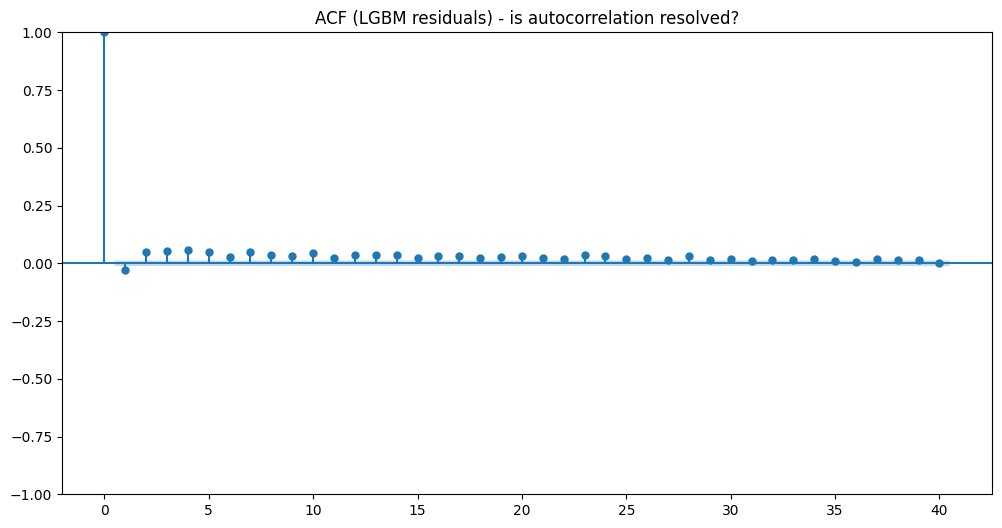

In [22]:
# --- Adding lags ---
cols_to_lag = [LOG_TARGET, 'PM10']
lag_degree = 1

for col in cols_to_lag:
    df_train[f"{col}_lag_{lag_degree}"] = df_train[col].shift(lag_degree)

df_train = df_train.iloc[lag_degree:]

# --- LGBMRegressor fit ---
X = df_train.drop(columns=[LOG_TARGET])
y = df_train[LOG_TARGET]

model_lgbm = lgb.LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        max_depth=20,
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=200,
        min_data_in_leaf=50,
        random_state=RANDOM_SEED,
        verbose=-1,
        n_jobs=jobs
        )

model_lgbm.fit(X, y)
y_pred_lgbm = model_lgbm.predict(X)
resid_lgbm = y - y_pred_lgbm

# --- Plot ACF residuals ---
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(resid_lgbm, lags=40, ax=ax)
ax.set_title("ACF (LGBM residuals) - is autocorrelation resolved?")
plt.show()

The plot is mostly flat with a few values occasionally going beyond statistical significance. To confirm that they are noise, we are using an additional diagnostic tool - `Durbin-Watson` test. It only checks autocorrelation up to the first lag, but it matches our AR(1) model.

In [23]:
# Durbin-Watson
dw = durbin_watson(resid_lgbm)
print("Durbin-Watson:", dw)

Durbin-Watson: 2.056209295065867


In [24]:
perform_VIF(df_train, list(df_train.columns), LOG_TARGET)

,feature,VIF
23,PM10_lag_1,8.393019
2,PM10,8.008480
12,month_cos,4.532633
22,log_PM2.5_lag_1,4.214060
11,month_sin,4.002614
7,PRES,3.762378
4,NO2,3.732616
5,CO,3.511772
20,RH,3.507980
18,season,3.169004


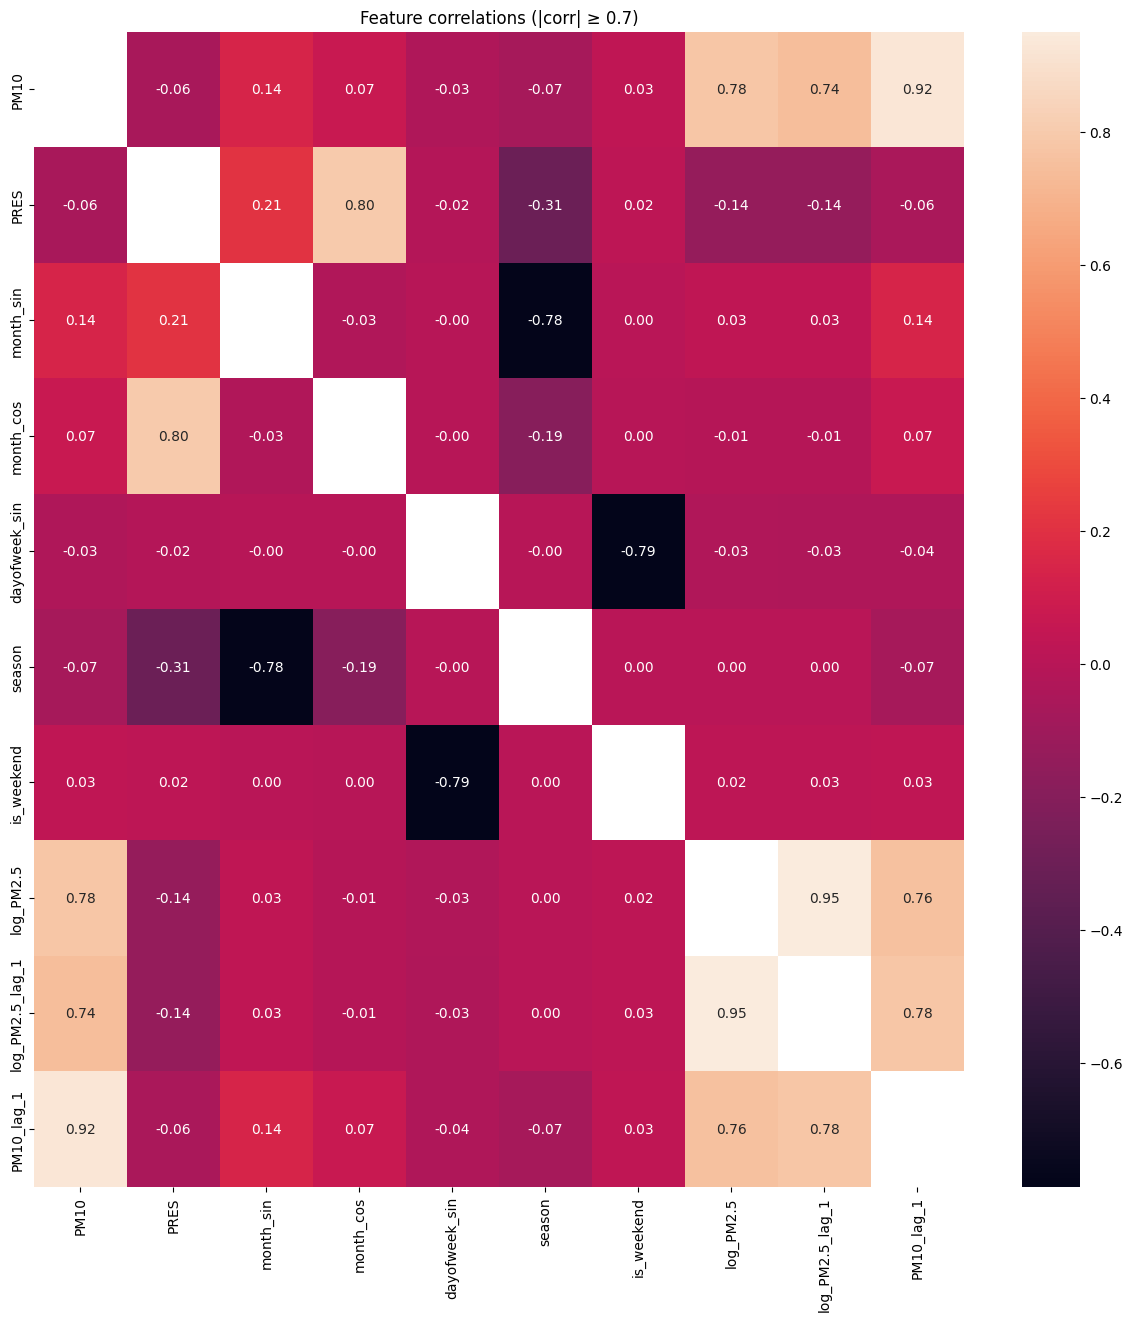

In [25]:
correlations = plot_correlations(df_train, df_train.columns.tolist(), f'Feature correlations', 0.7)

Autocorrelation has been successfully resolved. Adding lag terms fixes autocorrelation, but hurts interpretability of other features (since the lag dominates the regression). And because there is no equivalent to confidence intervals for coefficients in trees, we cannot check stability. 

We accept `VIF` = `8.4` and `Pearson`'s `0.92` and `0.95` to prioritize accuracy over interpretability as intended. The baseline is going to be interpreting power, it doesn't have the issues.

In [26]:
# apply the lags to the test set too
for col in cols_to_lag:
    df_test[f"{col}_lag_{lag_degree}"] = df_test[col].shift(lag_degree)

df_test = df_test.iloc[lag_degree:]

In [27]:
# remove the first row's residual/pred from sarimax result for consistency
resid_sarimax = resid_sarimax[1:]
y_pred_sarimax = y_pred_sarimax[1:]

In [28]:
numerical_continuous_cols.append('log_PM2.5_lag_1')
numerical_continuous_cols.append('PM10_lag_1')

### Homoscedasticity in residuals

The errors should be spread out evenly (be homoscedastic) in order for `p_values`, `CI`s, `t-tests` etc. to be valid.  

Since heteroscedasticity doesn't harm prediction accuracy directly, we might have skipped it for `LGBM`, but checking for it is an alternative that gives us a sanity check: if both models show the same variance pattern, then the variance issue is likely a data problem. If only `SARIMAX` shows it, then it is a `SARIMAX` / model-assumption issue.

The first step to account for heteroscedasticity is to log-transform the dependent variable, which we already did.

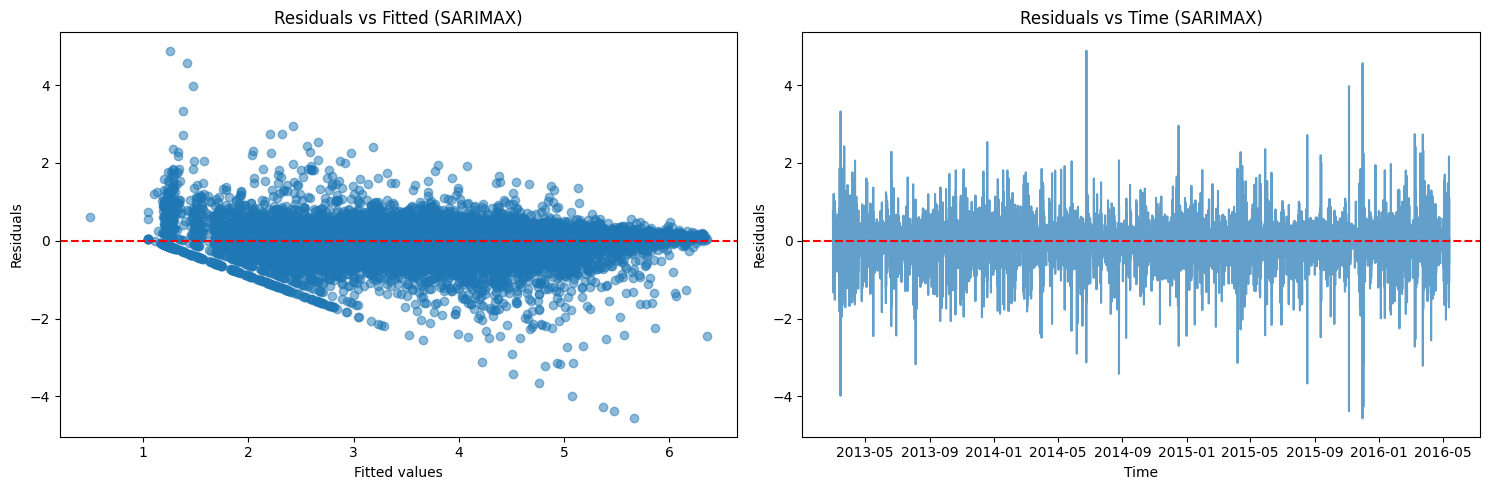

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residuals vs fitted
axes[0].scatter(y_pred_sarimax, resid_sarimax, alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted (SARIMAX)")

# Residuals vs time
axes[1].plot(resid_sarimax, alpha=0.7)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs Time (SARIMAX)")

plt.tight_layout()
plt.show()

In [33]:
X = sm.add_constant(X)
breusch_pagan_test(resid_sarimax, X)

Reject the null hypothesis: Heteroscedasticity is present.


Lagrange multiplier statistic,R2,p-value,f-value,f p-value
571.628175,0.020379,0.000000,25.348713,0.000000


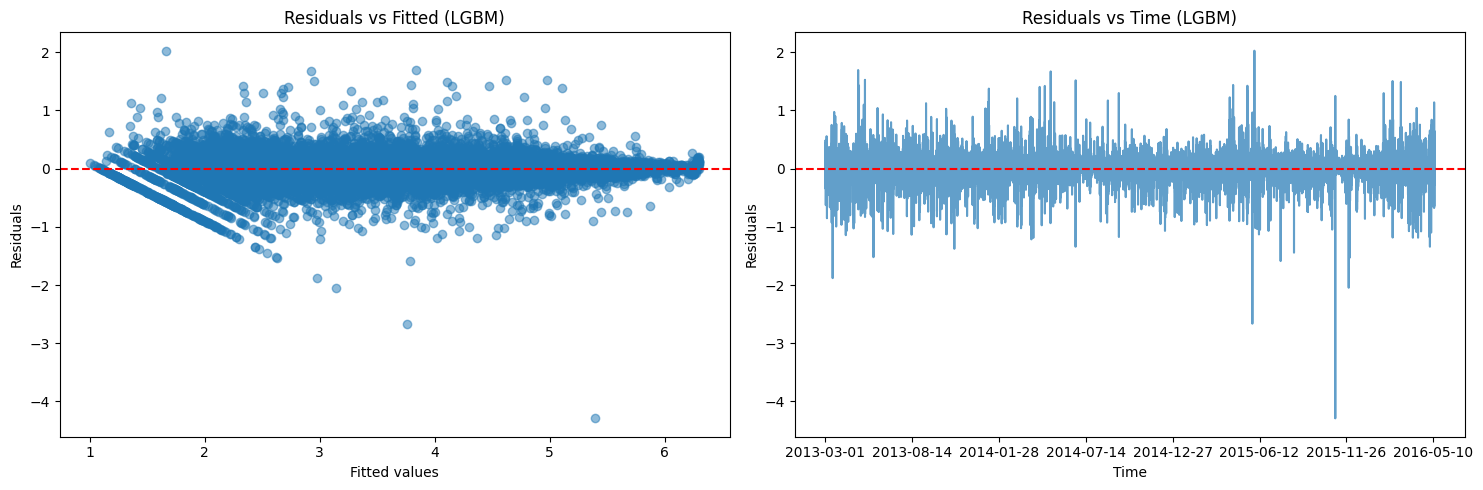

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residuals vs fitted
axes[0].scatter(y_pred_lgbm, resid_lgbm, alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted (LGBM)")

# Residuals vs time
axes[1].plot(resid_lgbm.index, resid_lgbm, alpha=0.7)  # <-- pass index explicitly
axes[1].axhline(0, color='red', linestyle='--')
resid_lgbm.index = pd.to_datetime(resid_lgbm.index)

step = 4000
xticks = resid_lgbm.index[::step]
axes[1].set_xticks(xticks)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs Time (LGBM)")

plt.tight_layout()
plt.show()


In [64]:
breusch_pagan_test(resid_lgbm, X)

Reject the null hypothesis: Heteroscedasticity is present.


Lagrange multiplier statistic,R2,p-value,f-value,f p-value
698.809553,0.024913,0.000000,31.132635,0.000000


Both `SARIMAX` and `LGBM` residuals exhibit statistically significant heteroscedasticity (`Breusch–Pagan`'s `p_value`→`0`). However, with `28,000`+ samples, even tiny effects will make `p_value` → `0`. Practically, only `~2–3%` of variance in squared residuals is explained, therefore heteroscedasticity is real, but weak. The plots confirm it, they are not showing a clean funnel shape, but heteroscedasticity is there, just not dominating. 

#### Summary

For inference (`SARIMAX`), robust errors would be safer (`HC3` robust covariance estimator); for prediction (`LGBM`), the impact is minimal, but necessitates abandoning the idea of tree interpretation completely.

The patterns are very alike for both plot groups of the two models, log-transformation didn't help either. Thus, it would be reasonable to state that heteroscedasticity is intrinsic for this data.

### Explaining heteroscedastic nature

#### Predictor-related heteroscedasticity

Plotting squared residuals (to remove the sign and make the magnitude more obvious) against each feature can show which features have dominant effect on heteroscedasticity.

c:\Users\Yur4ik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


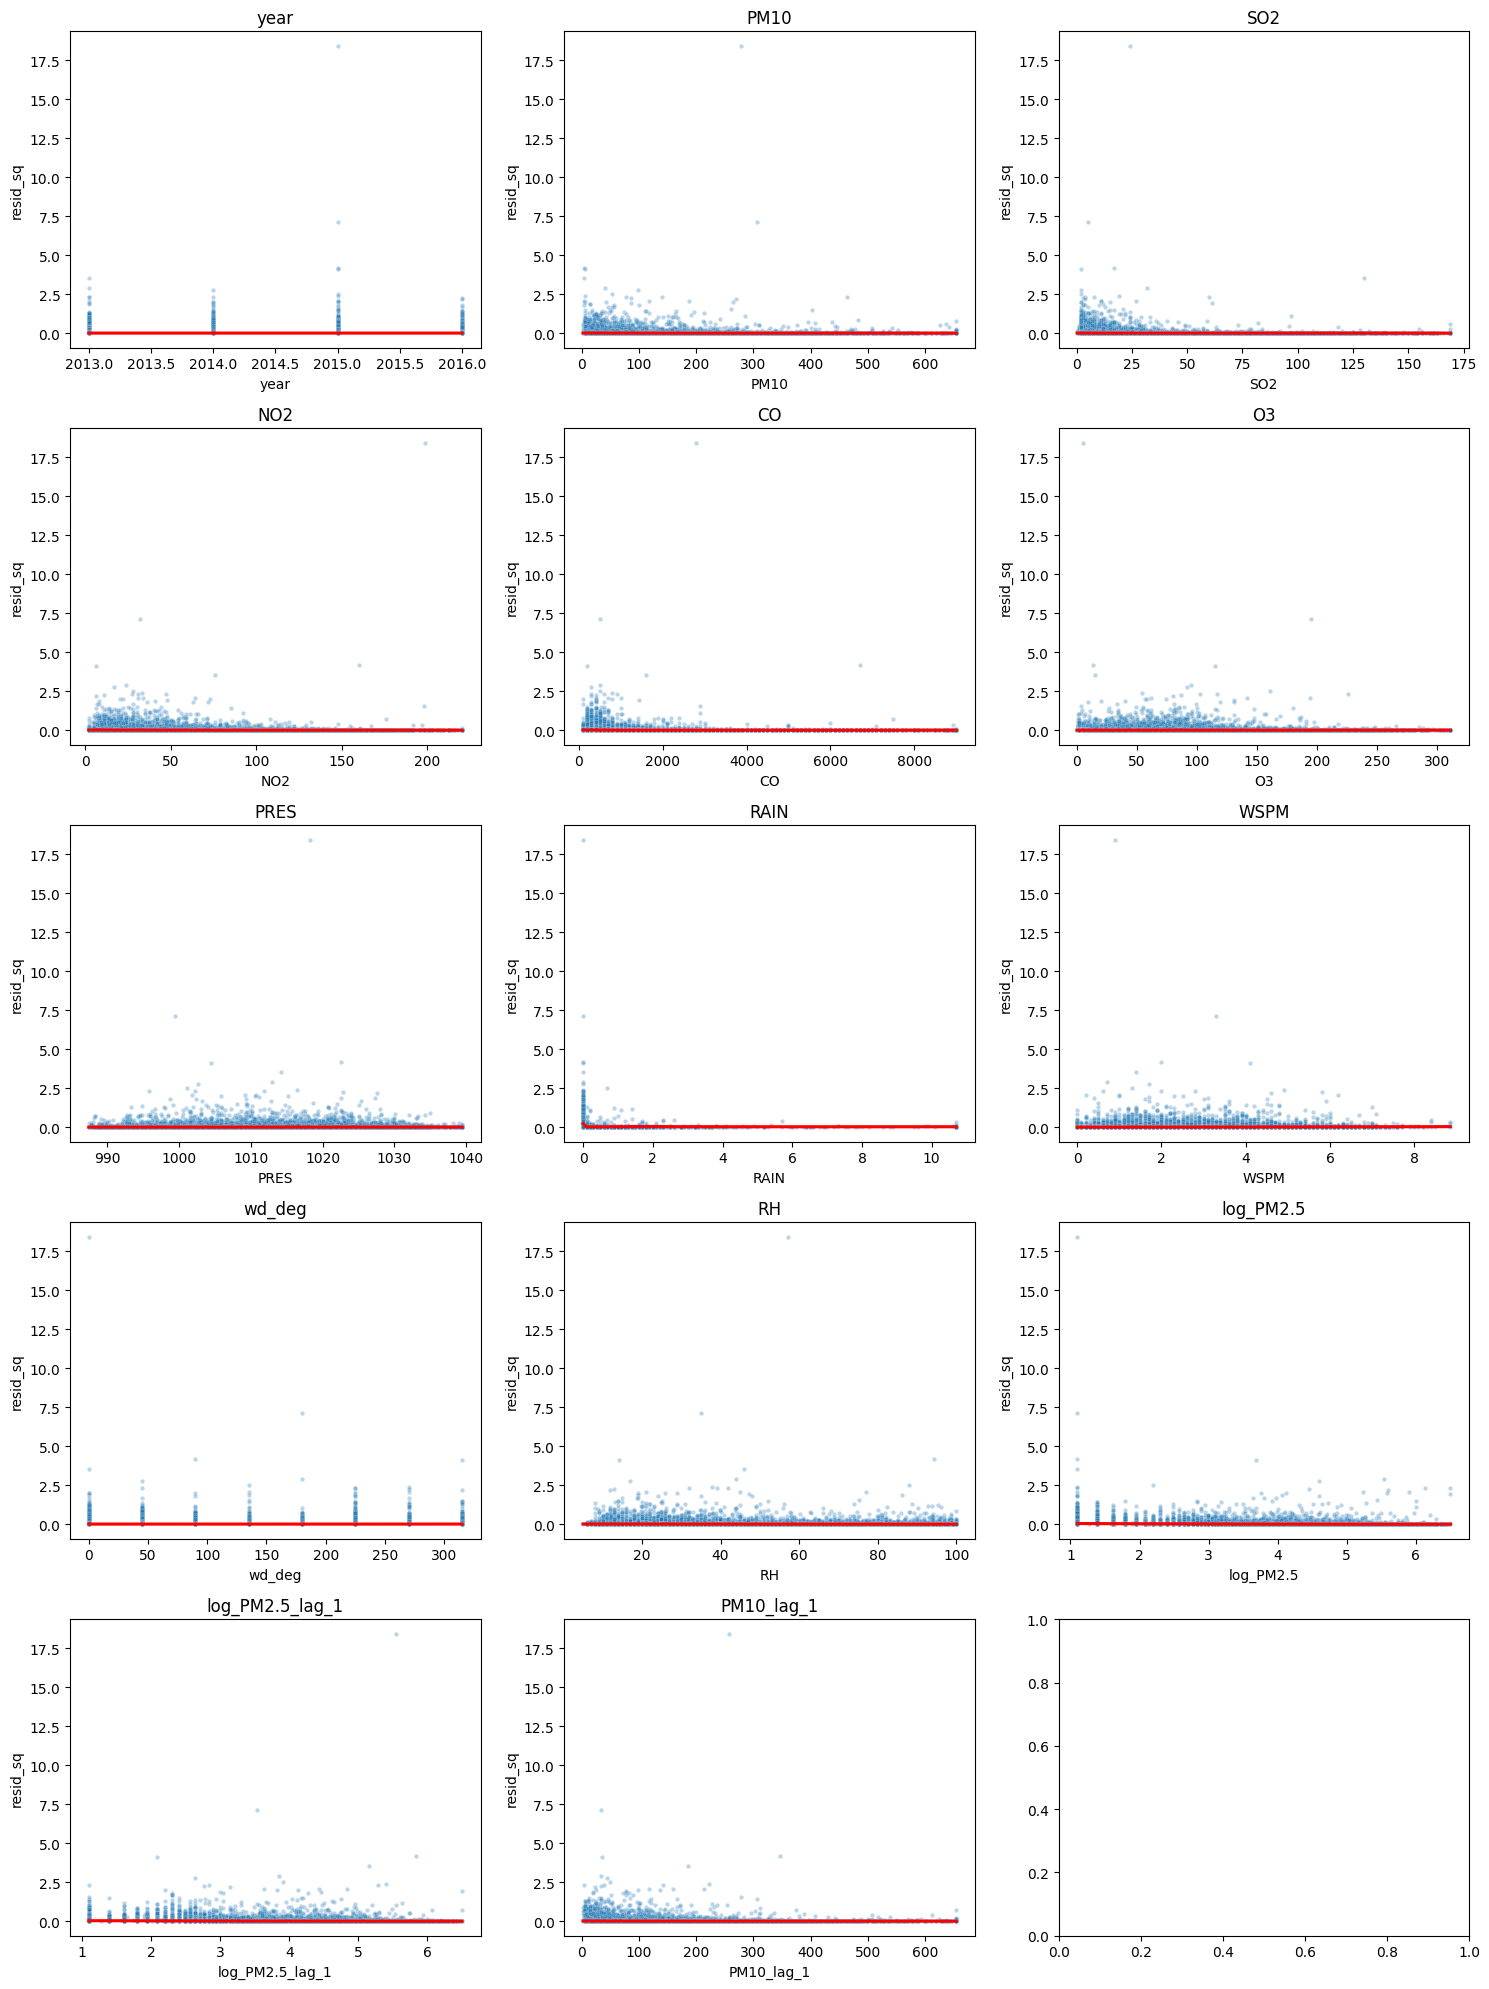

In [65]:
# make a new column with squared residuals
df_plot = df_train.copy()
df_plot["resid_sq"] = resid_lgbm**2

# plot in a grid
ncols = 3
nrows = -(-len(numerical_continuous_cols) // ncols)  # ceiling division
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows))

for ax, feat in zip(axes.flatten(), numerical_continuous_cols):
    sns.scatterplot(data=df_plot, x=feat, y="resid_sq", alpha=0.3, s=10, ax=ax)
    sns.regplot(data=df_plot, x=feat, y="resid_sq",
                scatter=False, lowess=True, ax=ax, color="red")
    ax.set_title(feat)

plt.tight_layout()
plt.show() # Flat cloud → no predictor-based heteroscedasticity.

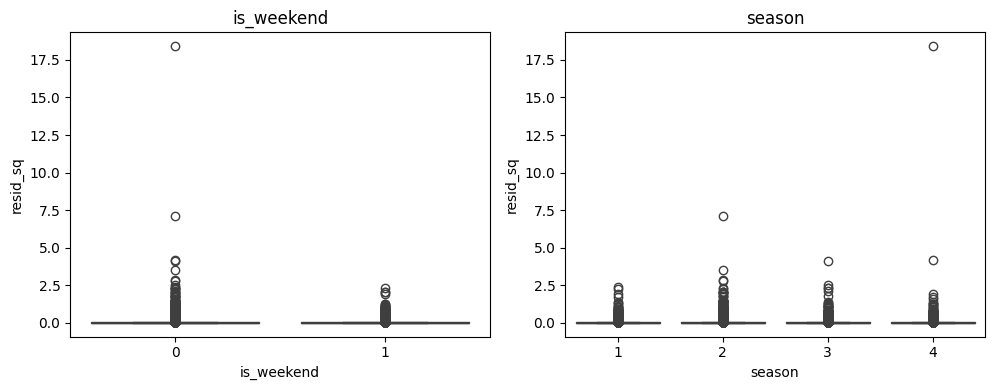

In [66]:
ncols = 3
cat_feats = ordinal_categorical_cols
nrows = -(-len(cat_feats) // ncols)  # ceiling division

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows))

for ax, feat in zip(axes.flatten(), cat_feats):
    sns.boxplot(data=df_plot, x=feat, y="resid_sq", ax=ax)
    ax.set_title(feat)

# If more axes than features, hide the empty ones
for ax in axes.flatten()[len(cat_feats):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


Plotting shows that neither single nor several features have dominant effect on heteroscedasticity, but they rather share it evenly. This also confirms the presumption about innateness of heteroscedasticity in the data. 

#### Time-related heteroscedasticity

Predictor-based heteroscedasticity is confirmed for both models. Now we are going to assess the impact of time-based heteroscedasticity in the data.

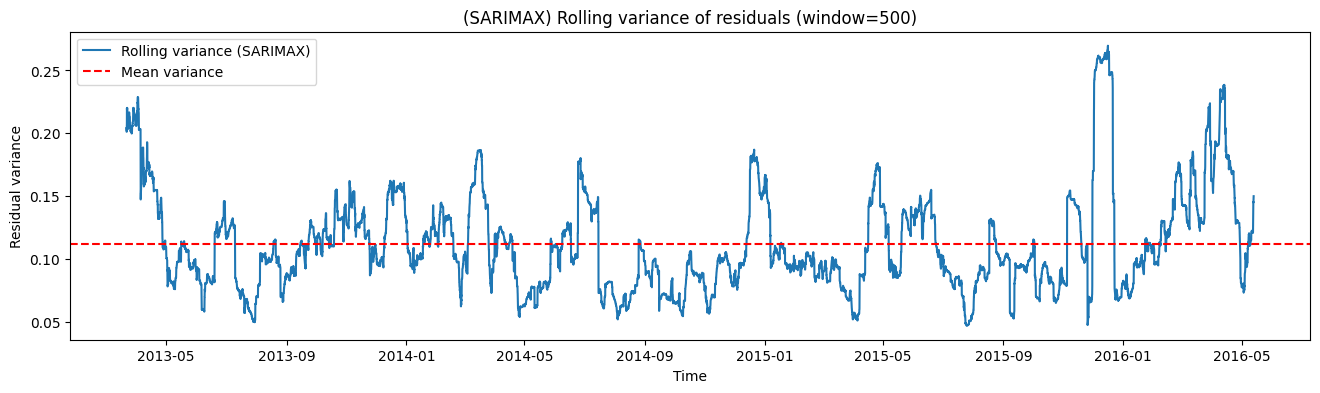

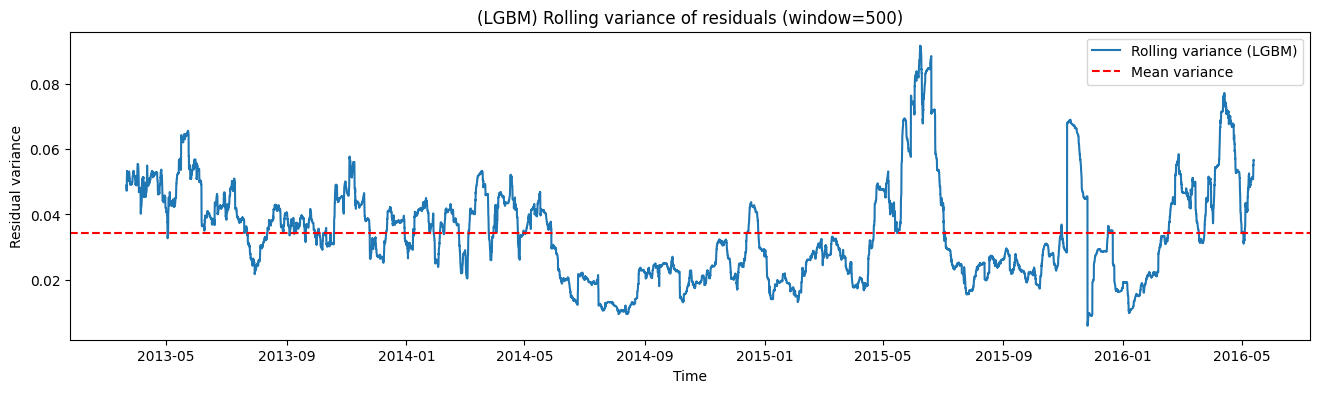

In [74]:
window = 500  # rolling window size
rolling_var_sarimax = resid_sarimax.rolling(window).var()
rolling_var_tree = resid_lgbm.rolling(window).var()

# SARIMAX
plt.figure(figsize=(16, 4))
plt.plot(rolling_var_sarimax, label="Rolling variance (SARIMAX)")
plt.axhline(rolling_var_sarimax.mean(), color="red", linestyle="--", label="Mean variance")
plt.xlabel("Time")
plt.ylabel("Residual variance")
plt.title(f"(SARIMAX) Rolling variance of residuals (window={window})")
plt.legend()
plt.show()

# Extra Trees
plt.figure(figsize=(16, 4))
plt.plot(rolling_var_tree, label="Rolling variance (LGBM)")
plt.axhline(rolling_var_tree.mean(), color="red", linestyle="--", label="Mean variance")
plt.xlabel("Time")
plt.ylabel("Residual variance")
plt.title(f"(LGBM) Rolling variance of residuals (window={window})")
plt.legend()
plt.show()


In [75]:
het_arch_test(resid_sarimax, 24)

Reject the null hypothesis: Heteroscedasticity is present.


Lagrange multiplier statistic,R2,p-value,f-value,f p-value
2466.217074,0.087922,0.000000,112.573570,0.000000


In [76]:
het_arch_test(resid_lgbm, 24)

Reject the null hypothesis: Heteroscedasticity is present.


Lagrange multiplier statistic,R2,p-value,f-value,f p-value
854.418501,0.030461,0.000000,36.687492,0.000000


Visually, heteroscedasticity is more significant for `LGBM`, but we can only plot so much. To quantify the whole effect, we are using the `Engle's test`. Time-based errors are also heteroscedastic, with `3%` variance explained in LGBM and `9%` in `SARIMAX`. We trust the second test because `SARIMAX` is capable of modelling time structure better.

##### Summary 

Ultimately, this is an inherent nature of the data and we cannot fix it (we could've regressed residuals to get custom weights for the model to level out the residuals though) entirely once and for all, it is going to occur in the future data most likely. There are not reasons to look for workarounds as in order for standard errors in interpretation to be valid, we are going to use robust covariance estimator - `HC3` and do nothing else for `LGBM` - its collinearity has already proved its interpretability is unreliable anyway.

## Interpretation

With all the necessary assumptions being held, we may start drawing conclusions. We don't need to perform bootstrap coefficient stability to be sure, nor we have to worry about heteroscedasticity thanks to the robust covariance estimator. It directly calculates a robust variance-covariance matrix for the model's parameters. This matrix corrects the standard errors to be valid even if the error terms have non-constant variance (heteroscedasticity).

In [85]:
X_interpret = df_train_interpret.drop(columns=[LOG_TARGET])
y_interpret = df_train_interpret[LOG_TARGET]

model = sm.tsa.SARIMAX(
            endog=y_interpret,
            exog=X_interpret,
            order=(1,0,1),
            seasonal_order=(1,0,1) + (24,),
            enforce_stationarity=True,
            enforce_invertibility=True
        )

baseline_model_hc3 = model.fit(disp=False, cov_type="robust")

In [86]:
baseline_model_hc3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          log_PM2.5   No. Observations:                28051
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               -4389.267
Date:                            Wed, 01 Oct 2025   AIC                           8826.535
Time:                                    14:00:59   BIC                           9024.337
Sample:                                03-01-2013   HQIC                          8890.205
                                     - 05-12-2016                                         
Covariance Type:                           robust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
year                      -0.0002      0.001     -0.308      0.758      -0.002       0.001
PM10                       0.0034      0.000     22.676      0.000       0.003       0.004
SO2                        0.0060      0.000     17.832      0.000       0.005       0.007
NO2                        0.0069      0.000     24.191      0.000       0.006       0.007
CO                      7.993e-05   9.19e-06      8.700      0.000    6.19e-05    9.79e-05
O3                         0.0022      0.000     13.092      0.000       0.002       0.003
PRES                       0.0030      0.001      2.128      0.033       0.000       0.006
RAIN                      -0.0286      0.005     -6.064      0.000      -0.038      -0.019
WSPM                      -0.0499      0.003    -17.329      0.000      -0.056      -0.044
hour_sin                  -0.0192      0.011     -1.692      0.091      -0.041       0.003
month_cos                 -0.0774      0.025     -3.114      0.002      -0.126      -0.029
day_sin                   -0.0201      0.017     -1.158      0.247      -0.054       0.014
day_cos                   -0.0022      0.017     -0.126      0.900      -0.036       0.031
dayofweek_cos             -0.0054      0.011     -0.482      0.630      -0.027       0.017
wd_deg                   2.18e-05   2.31e-05      0.946      0.344   -2.34e-05     6.7e-05
season                    -0.0698      0.012     -5.733      0.000      -0.094      -0.046
is_weekend                 0.0055      0.012      0.462      0.644      -0.018       0.029
RH                         0.0058      0.000     18.262      0.000       0.005       0.006
working_hour_component    -0.3144      0.016    -20.085      0.000      -0.345      -0.284
ar.L1                      0.8648      0.005    186.743      0.000       0.856       0.874
ma.L1                     -0.1557      0.015    -10.369      0.000      -0.185      -0.126
ar.S.L24                   0.2822      0.037      7.589      0.000       0.209       0.355
ma.S.L24                  -0.1303      0.038     -3.429      0.001      -0.205      -0.056
sigma2                     0.0883      0.002     45.383      0.000       0.084       0.092
===================================================================================
Ljung-Box (L1) (Q):                  26.89   Jarque-Bera (JB):            262032.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.75
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) des

In [87]:
params = baseline_model_hc3.params
conf   = baseline_model_hc3.conf_int()

# Build summary table
df_summary = pd.DataFrame({
    "predictor": params.index,
    "coef": params.values,
    "ci_low": conf[0].values,
    "ci_high": conf[1].values
})

# If your target was log-transformed:
df_summary["percentage"] = (np.exp(df_summary["coef"]) - 1) * 100
df_summary["odds_ci_low"] = np.exp(df_summary["ci_low"])
df_summary["odds_ci_high"] = np.exp(df_summary["ci_high"])

# Standardized effect size (for continuous predictors only):
# scaled_coef = beta * (std_x / std_y)
scaled = {}
for col in X.columns:
    if col in df_summary["predictor"].values:
        scaled[col] = params[col] * (X[col].std() / y.std())
df_summary["abs_scaled_coef"] = df_summary["predictor"].map(scaled).abs()

display(df_summary.sort_values(by='abs_scaled_coef', ascending=False))

,predictor,coef,ci_low,ci_high,percentage,odds_ci_low,odds_ci_high,abs_scaled_coef
1,PM10,0.003420,0.003125,0.003716,0.342633,1.003130,1.003723,0.299496
3,NO2,0.006854,0.006298,0.007409,0.687715,1.006318,1.007436,0.230252
17,RH,0.005841,0.005214,0.006468,0.585853,1.005228,1.006489,0.140938
2,SO2,0.006000,0.005341,0.006660,0.601822,1.005355,1.006682,0.135180
5,O3,0.002240,0.001904,0.002575,0.224217,1.001906,1.002578,0.115151
18,working_hour_component,-0.314390,-0.345069,-0.283711,-26.976573,0.708171,0.752985,0.112240
4,CO,0.000080,0.000062,0.000098,0.007993,1.000062,1.000098,0.088248
15,season,-0.069848,-0.093726,-0.045971,-6.746474,0.910533,0.955070,0.069980
8,WSPM,-0.049927,-0.055574,-0.044280,-4.870113,0.945942,0.956686,0.056853
10,month_cos,-0.077449,-0.126190,-0.028709,-7.452619,0.881447,0.971699,0.049695


##### Strong and reliable predictors
- `PM10` (coef=0.0034, %≈+0.34 per unit): Small raw coefficient, but stable and highly significant. Standardized effect size is the strongest overall (0.30). This confirms that `PM10` is the single most important driver of `PM2.5`.
- `NO2` (0.0069, +0.69%): Statistically strong and robust. Second-most influential gaseous pollutant. Standardized effect size is 0.23.
- `RH` (0.006, +0.59%) and `SO2` (0.006, +0.6%): Both highly significant, meaningful impact, reinforce the role of gaseous pollutants and humidity in `PM2.5` variability.
- `O3` (0.0022, +0.22%) and `working_hour_component` (-0.31, ≈-27%): Very large and negative effect for `working_hour_component` , strongly significant. Suggests working-hour periods are systematically associated with lower `PM2.5` (likely linked to diurnal people's activity or monitoring cycles). Equally important with positive `O3`.

##### Moderate predictors
- `season` (-0.07; -6.75%) and `month_cos` (-0.08, -7.5%): Strong negative effects. Seasonality matters a lot.
- `WSPM` (-0.05, -4.87%): Strong negative effect, highly significant. Higher wind speed disperses pollutants.
- `RAIN` (-0.03, -2.82%): Less significant, negative. Rainfall cleans the air.

##### Weak predictors
- `PRES` (0.003, 0.3%): Low significance, still has an impact.
- `CO` (0.00008, ≈0.008%): Statistically significant only due to large sample size (small raw coef.), negligible practical impact.

##### Unreliable predictors
- `day_sin`, `hour_sin`, `dayofweek_cos`, `is_weekend`, `wd_deg`, `day_cos`, `year`: All with tiny coefficients and `CI`s that often cross 0/1. Little to no explanatory power.

##### ARIMA structure terms
- `ar.L1` (0.86; 137%): Strong persistence → current `PM2.5` depends heavily on the previous observation.
- `ma.L1` (-0.16; -14.4%): Corrects for shock effects; negative value dampens noise from the previous step.
- `ar.S.L24` (0.28; 32.6%): Daily persistence → today’s `PM2.5` at a given hour depends on yesterday’s at the same hour.
- `ma.S.L24` (-0.13; -12.2%): Daily moving-average term reduces daily cyclical noise.
- `sigma2` (0.09; 9.23%): Residual variance, fairly small. Model explains most of the variability.

### Conclusion

The key drivers are `PM10`, `NO2`, `SO2`, `RH`, `season`, `month_cos`, `WSPM` and `RAIN` with the negligible factors of `PRES` and `CO`. The model captures both physical pollution drivers (`PM10`, gases, weather) and time-series memory (lags, daily cycles).

## Fine-Tuning

### Plan

Two-phase search is goin gto be performed:
- Phase A: exploring major axes with Bayesian search; limited trials to find the rough region.
- Phase B (situational): refining around Phase A best with a smaller grid.

In [29]:
X_train = df_train.drop(columns=[LOG_TARGET])
y_train = df_train[LOG_TARGET]

X_test = df_test.drop(columns=[LOG_TARGET])
y_test = df_test[LOG_TARGET]

For both phases `optuna` module is utilized. It performs fast and simple, selects parameters decisively without blindly testing each specified set. It is agile enough to take custom cross-validation split as well. The regular `cross_val_score` is not considered because:
- no early stopping support provided
- no access to train vs validation metrics
- no per-fold flexibility (if we want to pass a fold-specific validation set)

### Tuning

In [ ]:
def objective(trial, X, y):
    # shrinkage applied to each tree’s contribution
    lr = trial.suggest_float('learning_rate', 0.005, 0.2, log=True)
    # maximum number of leaves per tree (directly controls complexity). Higher = more flexible, can overfit.
    num_leaves = trial.suggest_int('num_leaves', 16, 64)
    # maximum depth of each tree. Bigger = more complex, smaller = more regularized
    max_depth = trial.suggest_int('max_depth', 6, 24)
    # minimum number of data points required in a leaf (prevents tiny leaves that overfit). Larger = smoother, less overfit.
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 200)
    # fraction of features to randomly select for each tree. Smaller = more randomness, less overfit, sometimes lower accuracy
    feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
    # fraction of samples used per tree. Smaller = more randomness, reduces variance.
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
    # how often to perform bagging (every k iterations). If 0, no bagging.
    bagging_freq = trial.suggest_int('bagging_freq', 0, 10)
    lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True)
    lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 100.0, log=True)
    # number of boosting iterations (trees)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)

    tss = TimeSeriesSplit(n_splits=5)
    val_scores_rmse = []
    train_scores_rmse = []
    val_scores_mae = []
    train_scores_mae = []
    train_r2_scores = []
    val_r2_scores = []

    for train_idx, val_idx in tss.split(X):
        Xtr, Xval = X.iloc[train_idx], X.iloc[val_idx]
        ytr, yval = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(
            learning_rate=lr, num_leaves=num_leaves, max_depth=max_depth,
            min_data_in_leaf=min_data_in_leaf, feature_fraction=feature_fraction,
            bagging_fraction=bagging_fraction, bagging_freq=bagging_freq,
            lambda_l1=lambda_l1, lambda_l2=lambda_l2, n_estimators=n_estimators,
            n_jobs=-1, random_state=RANDOM_SEED
        )
        model.fit(
            Xtr, ytr,
            eval_set=[(Xval, yval)],
            eval_metric='rmse',
            callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
        )

        pred_val = model.predict(Xval)
        pred_tr = model.predict(Xtr)

        train_scores_mae.append(mae_exp(ytr, pred_tr))
        val_scores_mae.append(mae_exp(yval, pred_val))

        train_scores_rmse.append(rmse_exp(ytr, pred_tr))
        val_scores_rmse.append(rmse_exp(yval, pred_val))

        train_r2_scores.append(r2_score(ytr, pred_tr))
        val_r2_scores.append(r2_score(yval, pred_val))


    # set all custom attrs to print out
    trial.set_user_attr("train_mae", float(np.mean(train_scores_mae)))
    trial.set_user_attr("val_mae", float(np.mean(val_scores_mae)))
    trial.set_user_attr("train_rmse", float(np.mean(train_scores_rmse)))
    trial.set_user_attr("val_rmse", float(np.mean(val_scores_rmse)))
    trial.set_user_attr("train_r2", float(np.mean(train_r2_scores)))
    trial.set_user_attr("val_r2", float(np.mean(val_r2_scores)))

    # return average val RMSE (optuna minimizes)
    return float(np.mean(val_scores_rmse))

In [93]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study.optimize(lambda t: objective(t, X_train, y_train), n_trials=200)

[I 2025-10-02 15:16:16,745] A new study created in memory with name: no-name-bdf85943-30ee-445a-8140-6d13bf76327c
[I 2025-10-02 15:16:27,157] Trial 0 finished with value: 18.08989228764213 and parameters: {'learning_rate': 0.019906996673933378, 'num_leaves': 62, 'max_depth': 19, 'min_data_in_leaf': 124, 'feature_fraction': 0.5780093202212182, 'bagging_fraction': 0.5779972601681014, 'bagging_freq': 0, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.010260065124896791, 'n_estimators': 1446}. Best is trial 0 with value: 18.08989228764213.
[I 2025-10-02 15:16:40,037] Trial 1 finished with value: 20.084995192373007 and parameters: {'learning_rate': 0.005394455304087533, 'num_leaves': 63, 'max_depth': 21, 'min_data_in_leaf': 50, 'feature_fraction': 0.5909124836035503, 'bagging_fraction': 0.5917022549267169, 'bagging_freq': 3, 'lambda_l1': 0.00052821153945323, 'lambda_l2': 0.00020866527711063722, 'n_estimators': 653}. Best is trial 0 with value: 18.08989228764213.
[I 2025-10-02 15:16:42,298] 

In [ ]:
best_params = study.best_params
best_val = study.best_trial.user_attrs['val_rmse']
best_train = study.best_trial.user_attrs['train_rmse']

In [128]:
best_val

15.827367052478323

### Is tuning complete?

We have performed 200 trials, having minimized `val_RMSE` up to `15.827`. To decide whether phase B is necessary, using `plot_optimization_history`, we plot a diagram that shows the objective values (validation `RMSE`s) across trials in the order Optuna ran them. According to it, the metric dropped steeply early (fewer than 50 iterations). Further improvements are insignificant. The search has likely converged; new trials aren’t beating the current best by much (or at all). We do not need more trials. The tuning is done.

In [99]:
optuna.visualization.plot_optimization_history(study)

In [96]:
best_params

{'learning_rate': 0.050082407314873414,
 'num_leaves': 37,
 'max_depth': 7,
 'min_data_in_leaf': 10,
 'feature_fraction': 0.9504633949190936,
 'bagging_fraction': 0.9797037164659682,
 'bagging_freq': 3,
 'lambda_l1': 6.160957792389373e-07,
 'lambda_l2': 0.043553728750044186,
 'n_estimators': 680}

In [115]:
results = pd.DataFrame(columns=['train_MAE', 'train_RMSE', 'train_R2', 'valid_MAE', 'valid_RMSE', 'valid_R2'])

results.loc['LGBM', 'train_MAE'] = study.best_trial.user_attrs['train_mae']
results.loc['LGBM', 'train_RMSE'] = study.best_trial.user_attrs['train_rmse']
results.loc['LGBM', 'train_R2'] = study.best_trial.user_attrs['train_r2']
results.loc['LGBM', 'valid_MAE'] = study.best_trial.user_attrs['val_mae']
results.loc['LGBM', 'valid_RMSE'] = study.best_trial.user_attrs['val_rmse']
results.loc['LGBM', 'valid_R2'] = study.best_trial.user_attrs['val_r2']

results

,train_MAE,train_RMSE,train_R2,valid_MAE,valid_RMSE,valid_R2
LGBM,7.460729,14.168880,0.972085,8.473056,15.827367,0.947686


### Regularization concerns

`train_R²` > `valid_R²`, but not significantly, `MAE` and `RMSE` are slightly worse on validation → very mild differences for overfitting. No regularization needed. We might consider it still if feature importances show some spurious variables dominate.

### Understanding complexity

In [100]:
optuna.visualization.plot_param_importances(study)

`min_data_in_leaf` = `0.62` → this was the dominant driver. How leaves are constrained had the strongest effect on validation RMSE.
`feature_fraction` = `0.09` and n_estimators = `0.07` → moderate importance, they matter but less.
`learning_rate` = `0.06`, max_depth = `0.06` → small but not negligible.
`everything` else (<`0.05`) → marginal effect in your search space.

So practically, if we need to shrink the tuning problem further, we are going to keep `min_data_in_leaf` wide open, and restrict others like `bagging_freq` or `lambda_l2` since they don’t move the needle.

### Best model fit and test assessment:

In [101]:
best_lgbm_model = lgb.LGBMRegressor(**best_params)
best_lgbm_model.fit(X_train, y_train)
best_lgbm_predictions = best_lgbm_model.predict(X_test)
    
mae = mae_exp(y_test, best_lgbm_predictions)
rmse = rmse_exp(y_test, best_lgbm_predictions)
r2 = r2_score(y_test, best_lgbm_predictions)

print(f"Test \tMAE: {mae}")
print(f"Test \tRMSE: {rmse}")
print(f"Test \tR2: {r2}")

Test 	MAE: 6.652580365717721
Test 	RMSE: 13.735616938515388
Test 	R2: 0.9524593800599508


The model performs better on test than on train and validation. Regularization concerns are completely off the table.

## Permutation importance to assess features

In [110]:
# disable scientific notation (e2, e-01 etc.)
np.set_printoptions(suppress=True, precision=6)
pd.set_option("display.float_format", "{:.6f}".format)

In [111]:
lgbm_r = permutation_importance(best_lgbm_model, X_test, y_test, n_repeats=10, random_state=RANDOM_SEED)
lgbm_importance = pd.Series(lgbm_r.importances_mean, index=X_test.columns)
lgbm_importance.sort_values(ascending=False)

PM10                      0.504957
log_PM2.5_lag_1           0.349875
CO                        0.042255
PM10_lag_1                0.022765
NO2                       0.008439
RH                        0.006088
O3                        0.004028
month_cos                 0.002437
working_hour_component    0.001249
SO2                       0.001174
PRES                      0.001011
hour_sin                  0.000964
WSPM                      0.000564
wd_deg                    0.000472
day_cos                   0.000134
dayofweek_cos             0.000127
RAIN                      0.000108
month_sin                 0.000048
season                    0.000018
day_sin                   0.000007
year                      0.000000
is_weekend               -0.000001
dayofweek_sin            -0.000039
dtype: float64

Practically, raw `year` has no impact. Seasonality must have been explained entirely through the lags. Dropping and retraining to validate:

In [127]:
X_train.drop(columns=['year', 'is_weekend'])

best_lgbm_model = lgb.LGBMRegressor(**best_params)
best_lgbm_model.fit(X_train, y_train)
best_lgbm_predictions = best_lgbm_model.predict(X_test)
    
mae = mae_exp(y_test, best_lgbm_predictions)
rmse = rmse_exp(y_test, best_lgbm_predictions)
r2 = r2_score(y_test, best_lgbm_predictions)

print(f"Test \tMAE: {mae}")
print(f"Test \tRMSE: {rmse}")
print(f"Test \tR2: {r2}")

Test 	MAE: 6.652580365717721
Test 	RMSE: 13.735616938515388
Test 	R2: 0.9524593800599508


Confirmed. `year` and `is_weekend` are redundant and may not be used.

## Save the data

In [ ]:
# saving numerical imputation model
joblib.dump(best_lgbm_model, os.path.join(data_folder_path, 'models', "PM2.5_best_lgbm_model.pkl"))

In [117]:
df_test[f'{TARGET}_pred'] = np.exp(best_lgbm_predictions)

df_test.to_csv(os.path.join(data_folder_path, 'processed', "04_df_test_predicted.csv"), index=True, index_label='datetime')

## Conclusion

The `SARIMAX` model identifies both environmental and temporal factors as significant determinants of `PM2.5` levels in Beijing. Among the exogenous predictors, `PM10` emerges as the strongest driver, with stable and highly significant effect. `NO2`, `SO2`, `O3` and relative humidity (`RH`) also exert consistent positive influences, underscoring the role of gaseous pollutants and meteorological conditions in shaping fine particulate concentrations. In contrast, wind speed and rainfall have significant negative effects, reflecting their dispersive and cleansing roles in air quality dynamics. The `working-hour component` exhibits a large and systematic negative association with `PM2.5`, while seasonal sinusoidal terms capture robust cyclical variation across the year.

Moderate effects are observed for `season` and `month_cos`, `WSPM` and `RAIN`. However, several variables including `day_sin`, `hour_sin`, `dayofweek_cos`, `is_weekend`, `wd_deg`, `day_cos`, `year effects, and most calendar-based terms—provide negligible or unreliable explanatory power, with confidence intervals encompassing null effects.

The `ARIMA` components confirm strong temporal dependence: a substantial non-seasonal autoregressive term (`AR1` ≈ 0.86) indicates high persistence from one hour to the next, complemented by moving-average adjustments (`MA1` ≈ –0.16). Seasonal terms capture daily persistence (`AR24` ≈ 0.28) and error correction (`MA24` ≈ –0.13). The residual variance (`σ²` ≈ 0.09) is small, indicating that most variability is explained by the combined exogenous and autoregressive structure.

In summary, `PM2.5` dynamics are jointly driven by pollutant precursors (mostly `PM10`, `NO2`, `SO2`, `RH`), meteorological conditions, and strong temporal persistence, while some calendar effects add little explanatory value.

The final predictive model follows `LGBM` algorithm and the best scores and parameters exhibit:

|Best model  | MAE (test) | RMSE (test) | R2 (test) |
|-----|-----|-----|-----|
| LGBM | 6.65 | 13.74 | 0.952 |